# Flight Delay Prediction

## Introduction

This project develops a machine learning model to predict flight delays (arrival delays exceeding 15 minutes) using historical flight data from the United States Department of Transportation's Bureau of Transportation Statistics. The primary objective is to demonstrate the end-to-end process of building a robust, interpretable, and scalable model while highlighting key data science concepts and MLOps practices.

The notebook emphasizes:
- **Data Manipulation**: Using `pandas` and `numpy` for efficient data handling.
- **Visualization**: Creating clear, accessible plots with `matplotlib` and `seaborn` to communicate insights effectively to non-technical stakeholders, a critical skill for data scientists.
- **Modeling**: Leveraging `sklearn`, `category_encoders`, and `xgboost` for preprocessing and classification.
- **MLOps**: Implementing a machine learning pipeline to standardize data preprocessing (target encoding for `ORIGIN` and `DEST`, Yeo-Johnson transformation for `DEP_DELAY`, and feature scaling) and model training, enhancing code readability and reducing errors.

By prioritizing reusable functions and pipeline automation, the code minimizes redundancy and potential mistakes, ensuring scalability and maintainability. The notebook is structured into four sections:
##### 1. **Data Exploration and Preprocessing**: Cleaning and transforming the dataset for modeling.
##### 2. **Model Building**: Constructing an ML pipeline with XGBoost for delay prediction.
##### 3. **Model Explainability**: Using SHAP to analyze feature importance and uncover delay drivers.
##### 4. **Discussion**: Translating insights into actionable strategies for operational efficiency and customer satisfaction.

This work showcases technical proficiency and business relevance of optimizing flight schedules and enhancing customer experience through data-driven decisions.

  

Dataset:  
The flight delay and cancellation data was downloaded from the United States Department of Transportation's Bureau of Transportation Statistics (https://www.transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr), whcih tracks the on-time performance of domestic flights operated by large air carriers.


Acknowledgement:  
I have learnt a lot from Farzad Nekouei's Kaggle notebook: "Flight Data | EDA to Preprocessing" (https://www.kaggle.com/code/farzadnekouei/flight-data-eda-to-preprocessing/notebook#Step-5.1-%7C-Irrelevant-Feature-Removal)


## 1 Data Exploration and Preprocessing
Objective: Load, explore, clean, and transform the dataset to make it suitable for modeling flight delays.

In [24]:
# Import Libraries

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and visualization
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Model explainability
import shap

# Date and time utilities
from datetime import time

# Machine learning pipelines and preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

# Categorical encoding
from category_encoders import TargetEncoder

# XGBoost classifier
from xgboost import XGBClassifier

# Model selection and evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import classification_report, roc_auc_score

### 1.1 Load the Data

In [25]:
# Load the dataset
df = pd.read_csv('flight.csv')

### 1.2 Dataset Basic Information

In [26]:
# Display the first 5 rows
df.head()

,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,...,DIVERTED,CRS_ELAPSED_TIME,ACTUAL_ELAPSED_TIME,AIR_TIME,DISTANCE,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY
0,1,2/3/2025 12:00:00 AM,AA,N101NN,302,JFK,LAX,1729,1726.0,-3.0,...,0.0,387.0,376.0,337.0,2475.0,NaN,NaN,NaN,NaN,NaN
1,1,2/3/2025 12:00:00 AM,AA,N101NN,307,LAX,JFK,805,822.0,17.0,...,0.0,324.0,315.0,272.0,2475.0,NaN,NaN,NaN,NaN,NaN
2,1,2/3/2025 12:00:00 AM,AA,N102NN,2305,JFK,SFO,1700,1754.0,54.0,...,0.0,410.0,427.0,389.0,2586.0,0.0,0.0,71.0,0.0,0.0
3,1,2/3/2025 12:00:00 AM,AA,N102NN,234,SFO,JFK,725,713.0,-12.0,...,0.0,334.0,311.0,276.0,2586.0,NaN,NaN,NaN,NaN,NaN
4,1,2/3/2025 12:00:00 AM,AA,N102NN,276,SFO,JFK,2253,2251.0,-2.0,...,0.0,336.0,309.0,277.0,2586.0,NaN,NaN,NaN,NaN,NaN


In [27]:
# Load the dataset description
meata_df = pd.read_csv('metadata.csv')
meata_df

,Field Name,Description
0,DAY_OF_WEEK,Day of Week
1,FL_DATE,Flight Date (yyyymmdd)
2,OP_UNIQUE_CARRIER,Unique Carrier Code.
3,TAIL_NUM,Tail Number
4,OP_CARRIER_FL_NUM,Flight Number
5,ORIGIN,Origin Airport
6,DEST,Destination Airport
7,CRS_DEP_TIME,CRS Departure Time (local time: hhmm)
8,DEP_TIME,Actual Departure Time (local time: hhmm)
9,DEP_DELAY,Difference in minutes between scheduled and ac...


In [28]:
# Rename the column for familiarity
df = df.rename(columns={'OP_UNIQUE_CARRIER': 'AIRLINE',
                        'OP_CARRIER_FL_NUM': 'FL_NUM',
                        'CRS_DEP_TIME': 'SCHE_DEP',
                        'DEP_TIME': 'ACTU_DEP',
                        'CRS_ARR_TIME': 'SCHE_ARR',
                        'ARR_TIME': 'ACTU_ARR',
                        'CRS_ELAPSED_TIME': 'EST_ELAPSED',
                        'ACTUAL_ELAPSED_TIME': 'ACTU_ELAPSED'})

In [29]:
# Check data types and count of non-null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504884 entries, 0 to 504883
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DAY_OF_WEEK          504884 non-null  int64  
 1   FL_DATE              504884 non-null  object 
 2   AIRLINE              504884 non-null  object 
 3   TAIL_NUM             504080 non-null  object 
 4   FL_NUM               504884 non-null  int64  
 5   ORIGIN               504884 non-null  object 
 6   DEST                 504884 non-null  object 
 7   SCHE_DEP             504884 non-null  int64  
 8   ACTU_DEP             497793 non-null  float64
 9   DEP_DELAY            497745 non-null  float64
 10  TAXI_OUT             497569 non-null  float64
 11  WHEELS_OFF           497569 non-null  float64
 12  WHEELS_ON            497343 non-null  float64
 13  TAXI_IN              497343 non-null  float64
 14  SCHE_ARR             504884 non-null  int64  
 15  ACTU_ARR         

##### Inferences:  
The dataset contains 504,884 entries (rows) and 28 columns.

The columns are of different data types:  
- integer (int64)  
- float (float64)  
- object (usually representing string or categorical data)  

The dataset contains some missing values. Specifically, the columns TAIL_NUM, DEP_TIME, DEP_DELAY, TAXI_OUT, WHEELS_OFF, WHEELS_ON, TAXI_IN, ARR_TIME, ARR_DELAY, ACTUAL_ELAPSED_TIME, AIR_TIME, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY and LATE_AIRCRAFT_DELAY have a certain number of non-null entries, indicating that there are some missing values in these columns.

Based on the data types and the feature explanations, we can see that the FL_NUM is indeed numerical in terms of data type, but categorical in terms of their semantics. Theis feature should be converted to string (object) data type for proper analysis and interpretation. The FL_DATE, SCHE_DEP, ACTU_DEP, WHEELS_OFF, WHEELS_ON, SCHE_ARR and ACTU_ARR are dates and times and should also be converted to datetime format for convenient. 

In [30]:
# Convert FL_NUM to object (string) data type
df['FL_NUM'] = df['FL_NUM'].astype(str)

# Convert to flight date to datetime format
df['FL_DATE'] = pd.to_datetime(df['FL_DATE']).dt.date

# Function that converts from the 'hhmm' numerical to datetime.time format 
def hhmm_to_time(value):
    """
    Converts a single 'hhmm' value to datetime.time.
    - Returns np.nan if value is null.
    - Converts 2400 to 0.
    """
    if pd.isnull(value):
        return np.nan
    
    value = int(value)
    
    if value == 2400:
        value = 0
    
    # Extract hour and minute using vectorized operations
    hour = value // 100
    minute = value % 100
    
    return time(hour, minute)

# List of columns to convert
time_columns = ['SCHE_DEP', 'ACTU_DEP', 'WHEELS_OFF', 'WHEELS_ON', 'SCHE_ARR', 'ACTU_ARR']

# Apply conversion
for col in time_columns:
    df[col] = df[col].apply(hhmm_to_time)

### 1.3 Summary Statistics for Numerical Variables

In [31]:
# Summary statistics for numerical columns
df.describe().T

,count,mean,std,min,25%,50%,75%,max
DAY_OF_WEEK,504884.0,4.001820,2.001488,1.0,2.0,4.0,6.0,7.0
DEP_DELAY,497745.0,11.700009,56.022276,-50.0,-6.0,-3.0,8.0,3403.0
TAXI_OUT,497569.0,19.204874,11.490288,1.0,12.0,16.0,22.0,291.0
TAXI_IN,497343.0,8.280098,6.571902,1.0,4.0,6.0,10.0,293.0
ARR_DELAY,496476.0,5.718929,58.828884,-91.0,-18.0,-7.0,9.0,3407.0
CANCELLED,504884.0,0.014667,0.120215,0.0,0.0,0.0,0.0,1.0
DIVERTED,504884.0,0.001987,0.044527,0.0,0.0,0.0,0.0,1.0
EST_ELAPSED,504884.0,150.687257,73.578586,9.0,95.0,135.0,183.0,1358.0
ACTU_ELAPSED,496476.0,145.054047,73.703649,17.0,91.0,130.0,178.0,761.0
AIR_TIME,496476.0,117.584818,71.708090,8.0,65.0,102.0,148.0,715.0


##### Inferences
- DAY_OF_WEEK: 1 for Monday, 7 for Sunday. It covers all possible values.  
- DEP_DELAY, ARR_DELAY: They show the departure and arrival delays in minutes. The values range from negative (early departure or arrival) to positive (late departure or arrival). The mean departure dealy and arrival delay are about 12 and 6 minutes respectively.  
- TAXI_OUT, TAXI_IN, EST_ELAPSED, ACTU_ELAPSED, AIR_TIME, CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY: - These features are shown in minutes.  
- CANCELLED, DIVERTED: They are binary classification, 1 for Yes, 0 for No.  
- DISTANCE: This is the total distance between the origin and destination airports. It varies from 31 to 5095 miles.  

### 1.4 Summary Statistics for Categorical Variables

In [32]:
# Get the summary statistics for categorical variables
df.describe(include='object')

,FL_DATE,AIRLINE,TAIL_NUM,FL_NUM,ORIGIN,DEST,SCHE_DEP,ACTU_DEP,WHEELS_OFF,WHEELS_ON,SCHE_ARR,ACTU_ARR
count,504884,504884,504080,504884,504884,504884,504884,497793,497569,497343,504884,497343
unique,28,14,5566,6340,330,330,1195,1386,1401,1440,1314,1440
top,2025-02-14,WN,N493HA,540,DFW,DFW,06:00:00,05:55:00,06:09:00,16:38:00,23:59:00,16:38:00
freq,19833,100199,271,255,22869,22857,11758,1261,757,580,2091,591


##### Inferences
- FL_DATE: There are 28 unique values as there are 28 days in February 2025 and the dataset only contains flights in Feb 2025.  
- AIRLINE: There are 14 unique carriers in the dataset.  
- TAIL_NUM, FL_NUM: They are unique identifiers associated with the aircraft and specific journeys. They have a large number of unique values.  
- ORIGIN, DEST: They are the airport codes from which the flight departed and at which it arrived. There are 330 unique origin airports and 105 unique destination airports in the dataset.  
- SCHE_DEP, ACTU_DEP, SCHE_ARR, ACTU_ARR: They are the scheduled and actual departure and arrival time of the flight and formatted as 'hh:mm:ss'.  
- WHEELS_OFF, WHEELS_ON: They are the timestamps of the aircraft wheels off and on and formatted as 'hh:mm:ss'.  

### 1.5 Completeness of the Dataset

In [33]:
# Count missing values for each column (axis=0 means column-wise)
missing_df = df.isnull().sum(axis=0).reset_index()

missing_df.columns = ['variable', 'missing values']

# Calculate the percentage of non-missing (filled) values per column
missing_df['filling factor (%)'] = (df.shape[0] - missing_df['missing values']) / df.shape[0] * 100

missing_df

,variable,missing values,filling factor (%)
0,DAY_OF_WEEK,0,100.000000
1,FL_DATE,0,100.000000
2,AIRLINE,0,100.000000
3,TAIL_NUM,804,99.840756
4,FL_NUM,0,100.000000
5,ORIGIN,0,100.000000
6,DEST,0,100.000000
7,SCHE_DEP,0,100.000000
8,ACTU_DEP,7091,98.595519
9,DEP_DELAY,7139,98.586012


In [34]:
# Calculate the number of cancelled and diverted flights
num_can_div_flight = ((df['CANCELLED'] == 1) | (df['DIVERTED'] == 1)).sum()
print(f"The number of cancelled or diverted flights: {num_can_div_flight}")

The number of cancelled or diverted flights: 8408


##### Inferences
- CARRIER_DELAY, WEATHER_DELAY, NAS_DELAY, SECURITY_DELAY, LATE_AIRCRAFT_DELAY: They have a large number of missing values since values were input only if it is a delayed flight. In other words, there are about 20% flights are delayed. These features are useful for deeper investigation of the causes of delay, but may not useful to predict whether a fight will arrive on time. I decide to drop out these columns after the exploratory data analysis.
- ARR_DELAY, AIR_TIME, ACTU_ELAPSED: They all have 8408 missing values, which is the same as the total number of cancelled or diverted flights. It is expected as the data is irrelevant if the flight is cancelled or diverted.
- The rest of the filling factors are quite good (> 98%). As the dataset is large, I decide to proceed by removing the entries that contain the missing values instead of imputing them.

### 1.6 Handle Missing Values

In [35]:
# List of columns to check for missing values
columns_to_check = ['TAIL_NUM', 'ACTU_DEP', 'DEP_DELAY',
                    'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON',
                    'TAXI_IN', 'ACTU_ARR', 'ARR_DELAY',
                    'ACTU_ELAPSED', 'AIR_TIME']

# Drop rows where any of these columns have NaN
eda_df = df.dropna(subset=columns_to_check)

# Check the summary of the dataset again
eda_df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 496476 entries, 0 to 504883
Data columns (total 28 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   DAY_OF_WEEK          496476 non-null  int64  
 1   FL_DATE              496476 non-null  object 
 2   AIRLINE              496476 non-null  object 
 3   TAIL_NUM             496476 non-null  object 
 4   FL_NUM               496476 non-null  object 
 5   ORIGIN               496476 non-null  object 
 6   DEST                 496476 non-null  object 
 7   SCHE_DEP             496476 non-null  object 
 8   ACTU_DEP             496476 non-null  object 
 9   DEP_DELAY            496476 non-null  float64
 10  TAXI_OUT             496476 non-null  float64
 11  WHEELS_OFF           496476 non-null  object 
 12  WHEELS_ON            496476 non-null  object 
 13  TAXI_IN              496476 non-null  float64
 14  SCHE_ARR             496476 non-null  object 
 15  ACTU_ARR             4

### 1.7 Univariate Analysis

#### 1.7.1 Day of Month
Number of flights across the days of the month

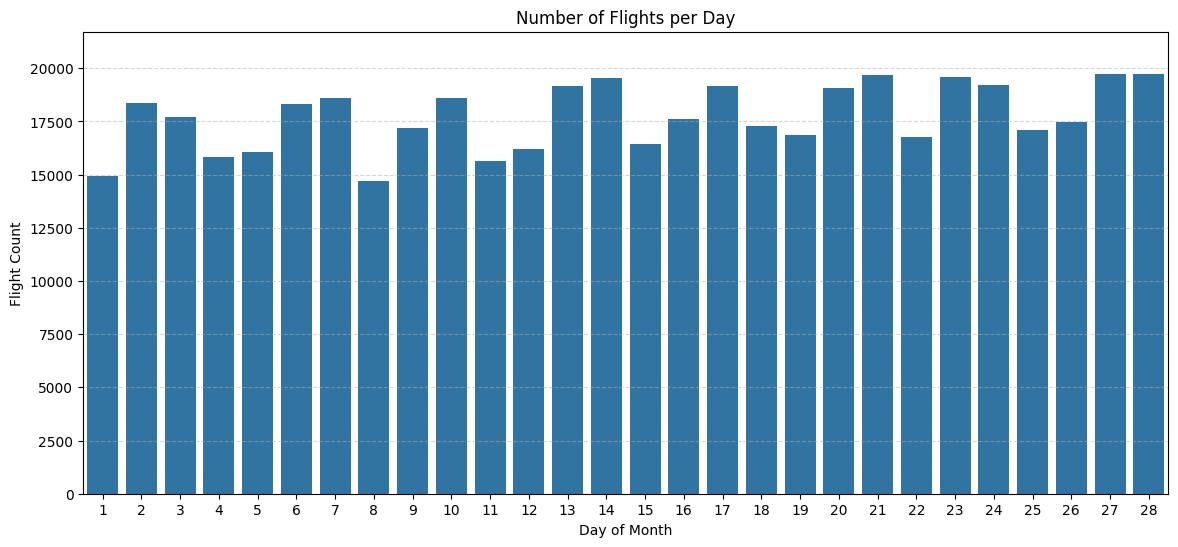

In [36]:
# Count number of flights per day
daily_counts = eda_df.groupby(['FL_DATE']).size()

# Convert to DataFrame for plotting
daily_df = daily_counts.reset_index()
daily_df.columns = ['Date', 'Flight Count']
daily_df['Day of Month'] = pd.to_datetime(daily_df['Date']).dt.day

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=daily_df, x='Day of Month', y='Flight Count')

# Formatting
plt.title('Number of Flights per Day')
plt.ylim(0, daily_df['Flight Count'].max() * 1.1)  # y-axis starts at 0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The bar chart reveals a more or less uniform distribution of flights across the days of month.

#### 1.7.2 Day of Week
Number of average flights across the day of week

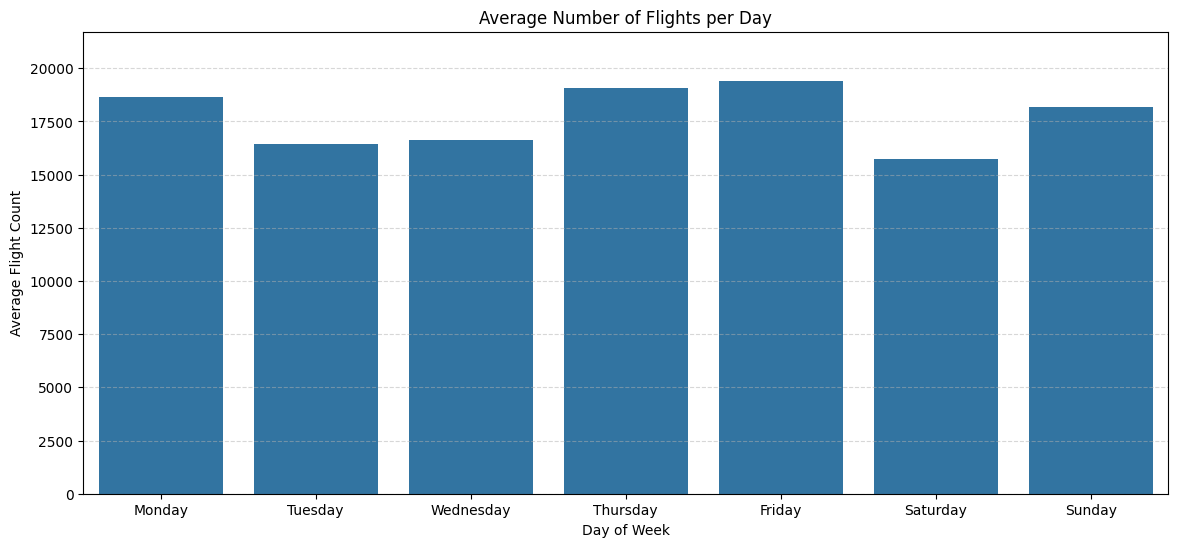

In [37]:
# Count flights per day and retain day of week
date_counts = eda_df.groupby(['FL_DATE', 'DAY_OF_WEEK']).size()

# Calculate average flights per day of week
avg_by_day_agg = date_counts.groupby(['DAY_OF_WEEK']).mean()

# Convert to DataFrame for plotting
avg_by_day_df = avg_by_day_agg.reset_index()
avg_by_day_df.columns = ['Day of Week', 'Average Flight Count']

# Map numeric day to weekday name
day_map = {
    1: 'Monday', 2: 'Tuesday', 3: 'Wednesday', 4: 'Thursday',
    5: 'Friday', 6: 'Saturday', 7: 'Sunday'
}
avg_by_day_df['Day of Week'] = avg_by_day_df['Day of Week'].map(day_map)

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=avg_by_day_df, x='Day of Week', y='Average Flight Count')

# Formatting
plt.title('Average Number of Flights per Day')
plt.ylim(0, daily_df['Flight Count'].max() * 1.1)  # y-axis starts at 0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The bar chart reveals a more or less uniform distribution of flights across the days of week.

#### 1.7.3 Schedule Departure Time
Scheduled number of departure flights in each hour

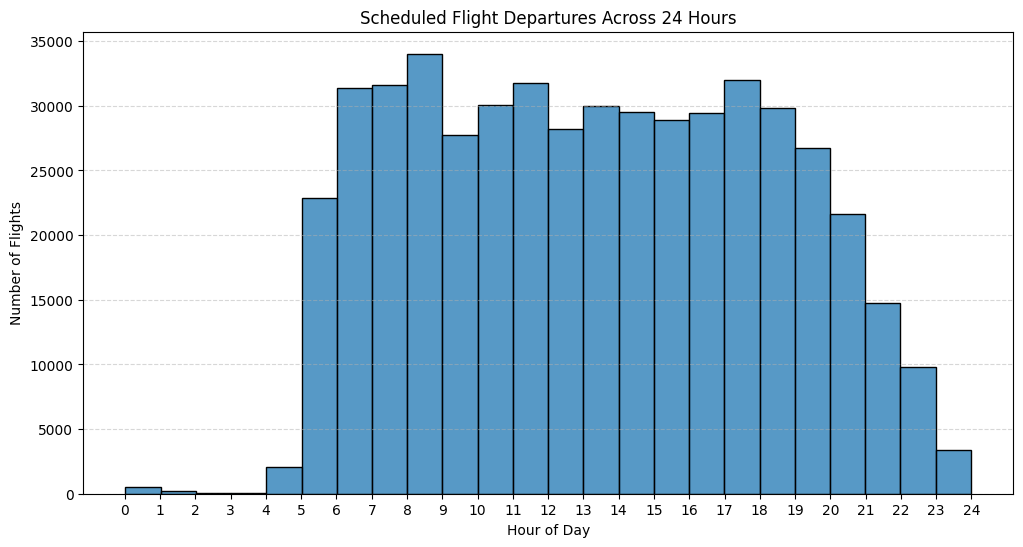

In [38]:
# Function that converts datetime.time to decimal hour
def time_to_hour(time):
    if pd.isnull(time):  # Handle missing values
        return np.nan 
    return time.hour + time.minute / 60

# Apply time to hour conversion
sche_dep_df = eda_df['SCHE_DEP'].apply(time_to_hour)

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=sche_dep_df, bins=24)

# Formatting
plt.title('Scheduled Flight Departures Across 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram shows that most flights are scheduled to depart between 06:00 to 18:00. There are much fewer flights departing between 23:00 to 04:00.

#### 1.7.4 Actual Departure Time
Actual number of departure flights in each hour

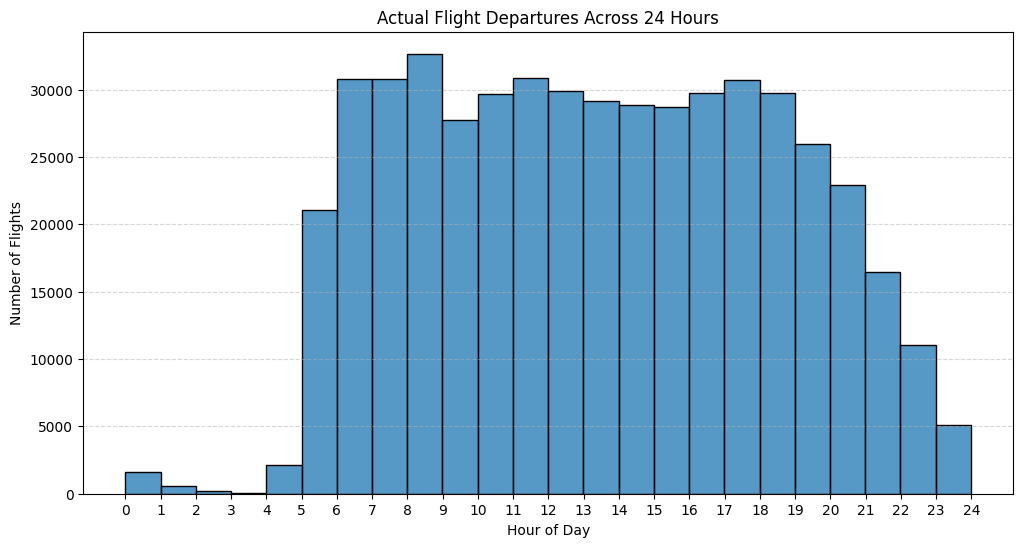

In [39]:
# Apply time to hour conversion
actu_dep_df = eda_df['ACTU_DEP'].apply(time_to_hour)

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=actu_dep_df, bins=24)

# Formatting
plt.title('Actual Flight Departures Across 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


##### Inference:
The histogram is similar to the scheduled departure time histogram. It also shows that most flights actually departs between 06:00 to 18:00 and there are much fewer flights departing between 23:00 to 04:00.

#### 1.7.5 Departure Delay
Departure delay is the difference in minutes between scheduled and actual departure time. Negative values indicate early departures.

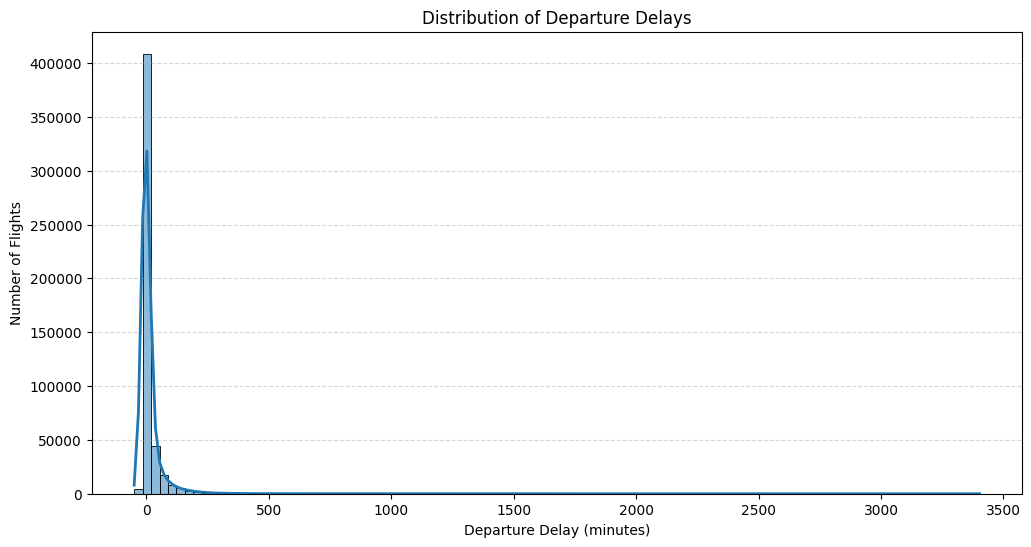

In [40]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['DEP_DELAY'], bins=100, kde=True, kde_kws={'bw_adjust': 4}, line_kws={'linewidth':2})

# Formatting
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
- The ditribution is heavily skewed and the peak is around 0 minute. It is better to another histogram with the delay time up to 1 hour for better visualization.
- The long tail toward 3500 minutes shows a few outlier flights with very large delays.

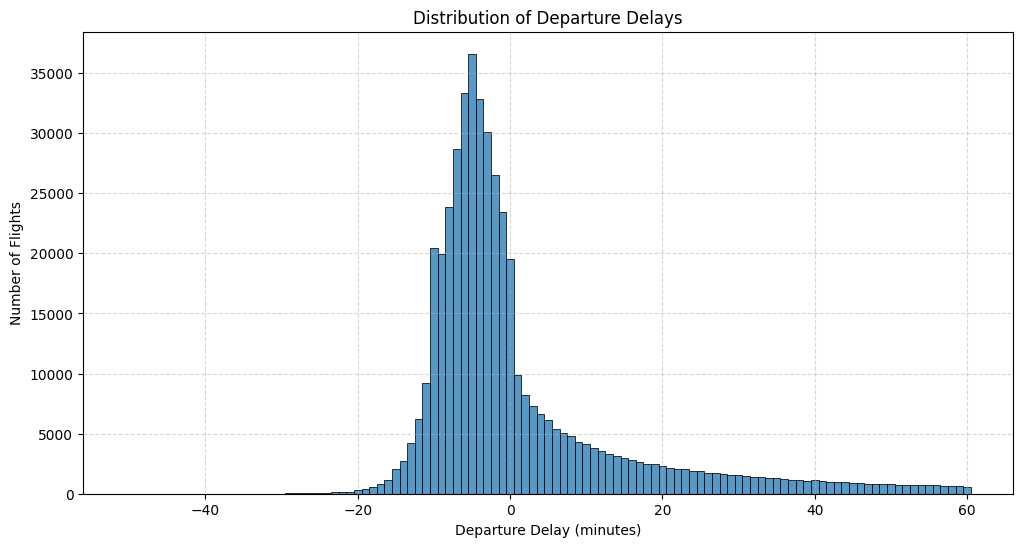

In [41]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['DEP_DELAY'], binrange=(min(eda_df['DEP_DELAY']),60), discrete=True)

# Formatting
plt.title('Distribution of Departure Delays')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram indicates that most flights depart slightly earlier than the scheduled departure time, as the peak of the distribution is -5 minutes.

#### 1.7.6 Schedule Arrival Time
Scheduled number of arrival flights in each hour

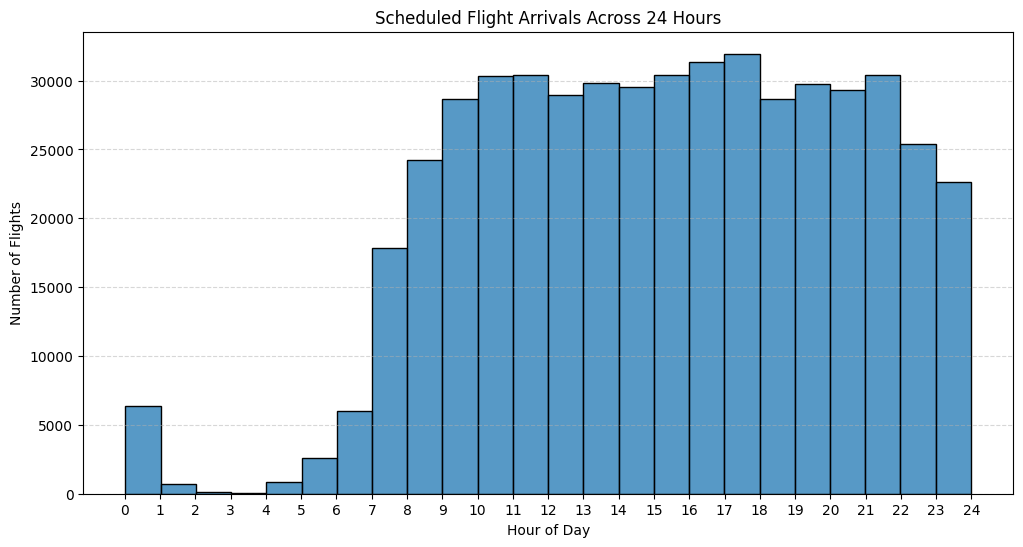

In [42]:
# Apply time to hour conversion
sche_arr_df = eda_df['SCHE_ARR'].apply(time_to_hour)

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=sche_arr_df, bins=24)

# Formatting
plt.title('Scheduled Flight Arrivals Across 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


##### Inference:
The histogram shows that most flights are scheduled to arrive between 09:00 to 21:00. There are much fewer flights arriving between 00:00 to 06:00.

#### 1.7.7 Actual Arrival Time
Actual number of arrival flights in each hour

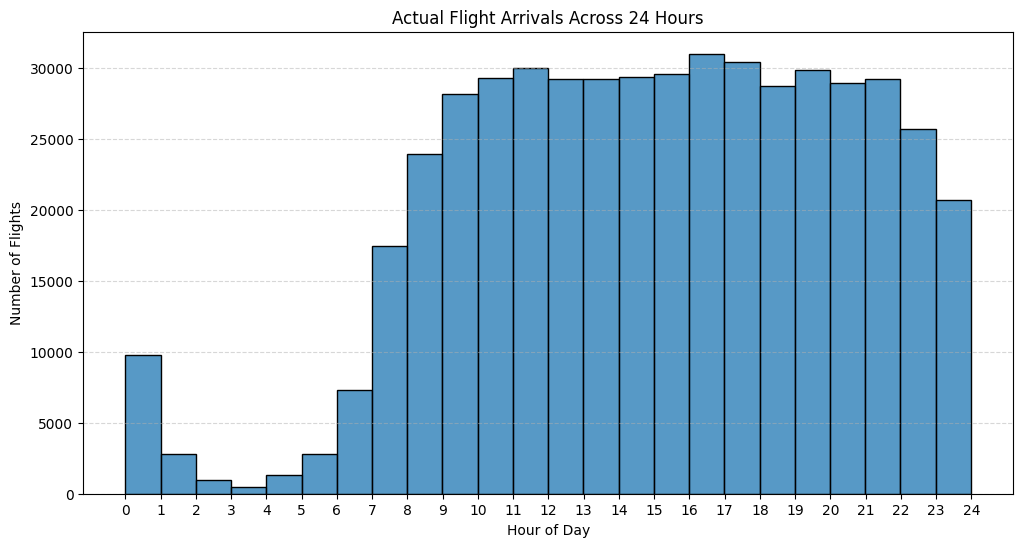

In [43]:
# Apply time to hour conversion
actu_arr_df = eda_df['ACTU_ARR'].apply(time_to_hour)

# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=actu_arr_df, bins=24)

# Formatting
plt.title('Actual Flight Arrivals Across 24 Hours')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Flights')
plt.xticks(range(0, 25))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram is similar to the scheduled arrival time histogram. It also shows that most flights actually arrives between 09:00 to 21:00 and there are much fewer flights arriving between 00:00 to 06:00.

#### 1.7.8 Arrival Delay
Arrival delay is the difference in minutes between scheduled and actual arrival time. Negative values indicate early departures.

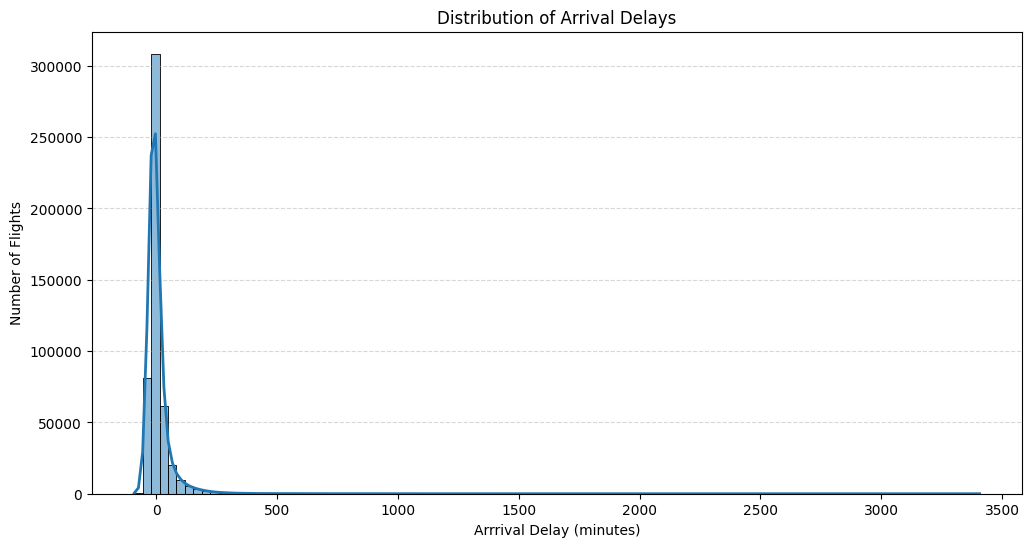

In [44]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['ARR_DELAY'], bins=100, kde=True, kde_kws={'bw_adjust': 4}, line_kws={'linewidth':2})

# Formatting
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrrival Delay (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
- The ditribution is heavily skewed and the peak is around 0 minute. It is better to another histogram with the delay time up to 1 hour for better visualization.
- The long tail toward 3500 minutes shows a few outlier flights with very large delays.

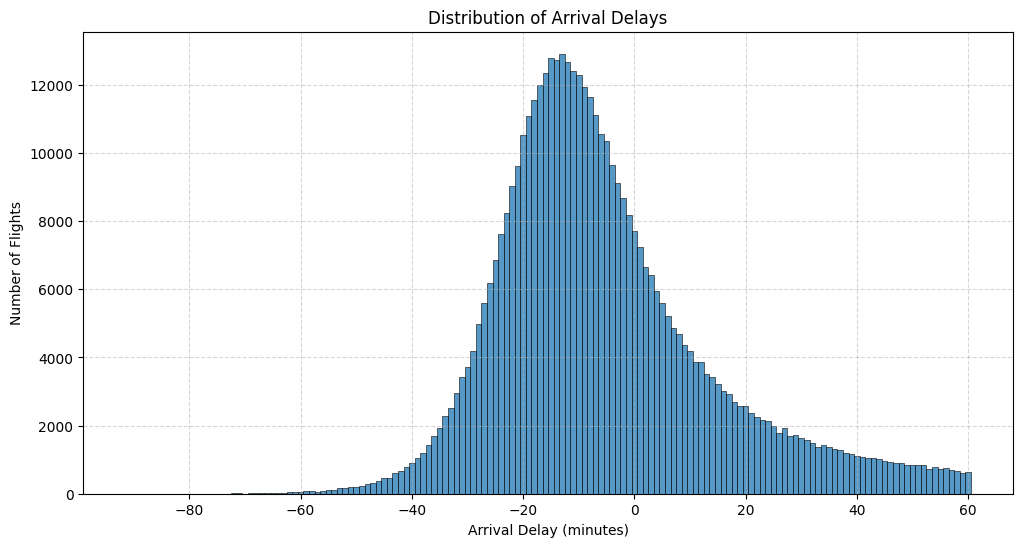

In [45]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['ARR_DELAY'], binrange=(min(eda_df['ARR_DELAY']),60), discrete=True)

# Formatting
plt.title('Distribution of Arrival Delays')
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram indicates that most flights arrive on time or even slightly early, as the peak of the distribution is -13 minutes.

#### 1.7.9 Airline
Number of flights operated by each airline carrier

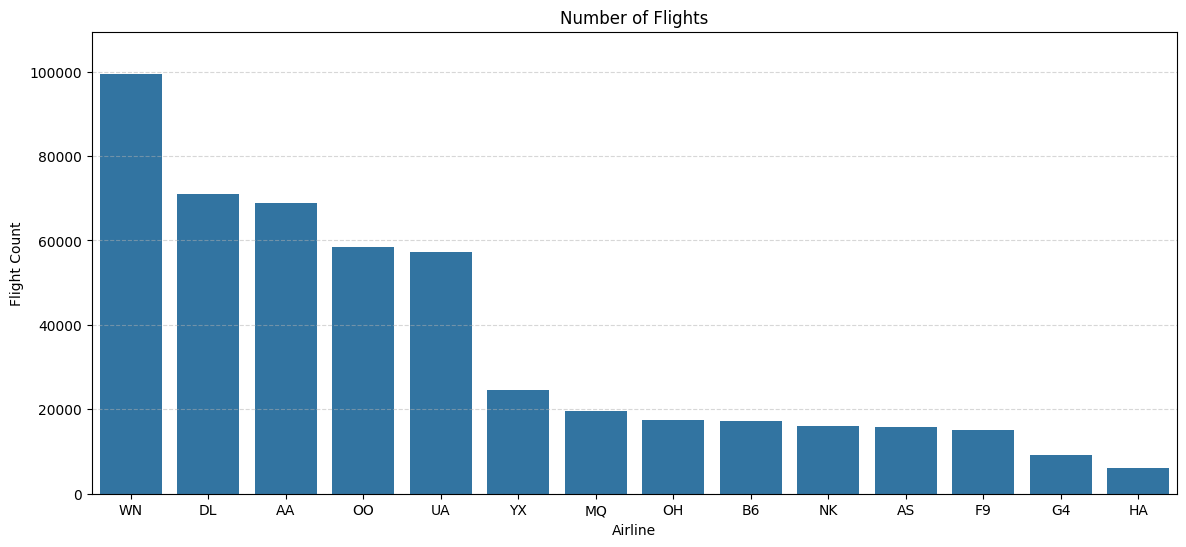

In [46]:
# Count number of flights per airline
airline_counts = eda_df.groupby(['AIRLINE']).size()

# Convert to DataFrame for plotting
airline_df = airline_counts.sort_values(ascending=False).reset_index()
airline_df.columns = ['Airline', 'Flight Count']

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=airline_df, x='Airline', y='Flight Count')

# Formatting
plt.title('Number of Flights')
plt.ylim(0, airline_df['Flight Count'].max() * 1.1)  # y-axis starts at 0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The bar chart shows that WN, DL and AA are the top 3 airlines operating the most flights in Feb 2025.

#### 1.7.10 Origin Airport
Number of flights departing from the origin airport

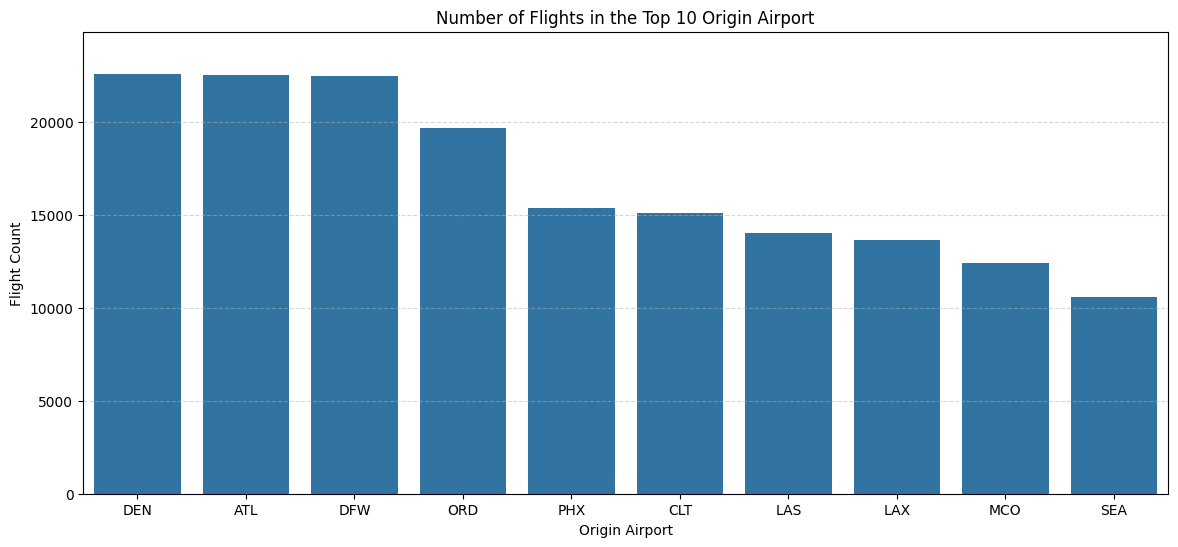

In [47]:
# Count number of flights per origin airport
origin_counts = eda_df.groupby(['ORIGIN']).size()

# Convert to DataFrame for plotting
origin_df = origin_counts.sort_values(ascending=False).reset_index()
origin_df.columns = ['Origin Airport', 'Flight Count']

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=origin_df[:10], x='Origin Airport', y='Flight Count') # Plot the top 10 origin airport

# Formatting
plt.title('Number of Flights in the Top 10 Origin Airport')
plt.ylim(0, origin_df['Flight Count'].max() * 1.1)  # y-axis starts at 0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The bar chart shows that DEN, ATL and DFW are the top 3 most common origin airport in Feb 2025.

#### 1.7.11 Destination Airport
Number of flights arriving to the destination airport

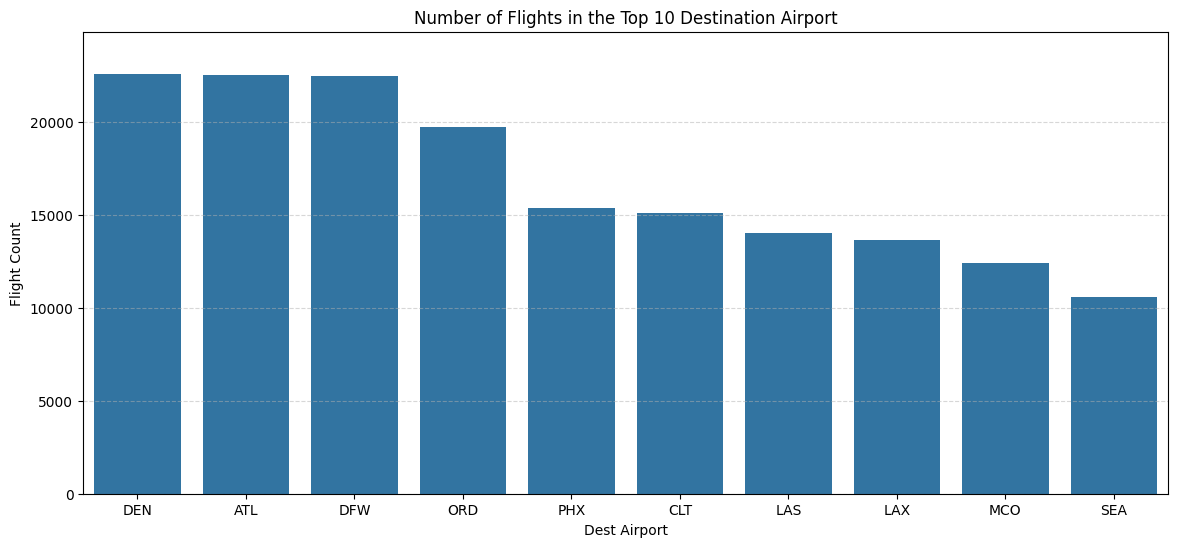

In [48]:
# Count number of flights per destination airport
dest_counts = eda_df.groupby(['DEST']).size()

# Convert to DataFrame for plotting
dest_df = dest_counts.sort_values(ascending=False).reset_index()
dest_df.columns = ['Dest Airport', 'Flight Count']

# Plot bar chart
plt.figure(figsize=(14, 6))
sns.barplot(data=dest_df[:10], x='Dest Airport', y='Flight Count') # Plot the top 10 destination airport

# Formatting
plt.title('Number of Flights in the Top 10 Destination Airport')
plt.ylim(0, dest_df['Flight Count'].max() * 1.1)  # y-axis starts at 0
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The bar chart shows that DEN, ATL and DFW are the top 3 most common destination airport in Feb 2025, similar to the origin airports.

#### 1.7.12 Estimated Elapsed Time
The estimated time of an aircraft spends from the first movement of the origin to the complete stop at the destination.

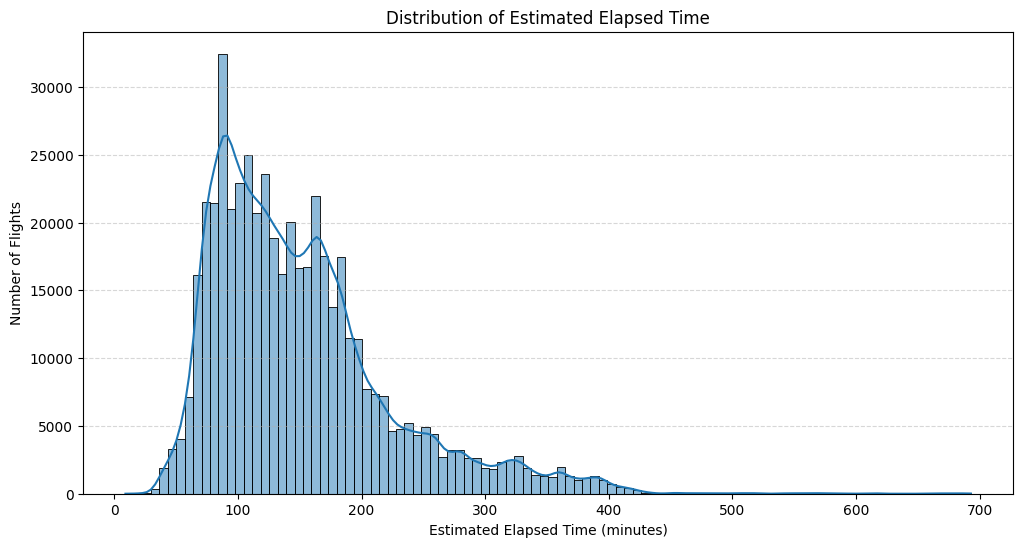

In [49]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['EST_ELAPSED'], bins=100, kde=True)

# Formatting
plt.title('Distribution of Estimated Elapsed Time')
plt.xlabel('Estimated Elapsed Time (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram shows that most flights have an estimated elapsed time of around 100 to 200 minutes, with a few flights having significantly longer elapsed times.

#### 1.7.13 Actual Elapsed Time
The actual time of an aircraft spends from the first movement of the origin to the complete stop at the destination.

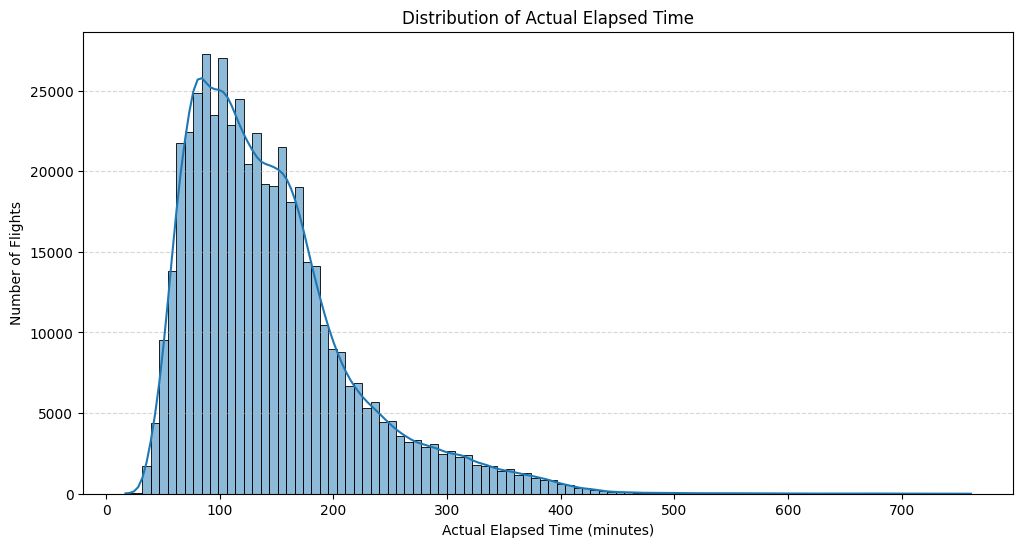

In [50]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['ACTU_ELAPSED'], bins=100, kde=True)

# Formatting
plt.title('Distribution of Actual Elapsed Time')
plt.xlabel('Actual Elapsed Time (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram shows that most flights have an actual elapsed time of around 100 to 200 minutes, with a few flights having significantly longer elapsed times, similar to the estimated elapsed time.

#### 1.7.14 Air Time
The time of an aircraft spends in the air, which is also the duration between wheels up to wheels down

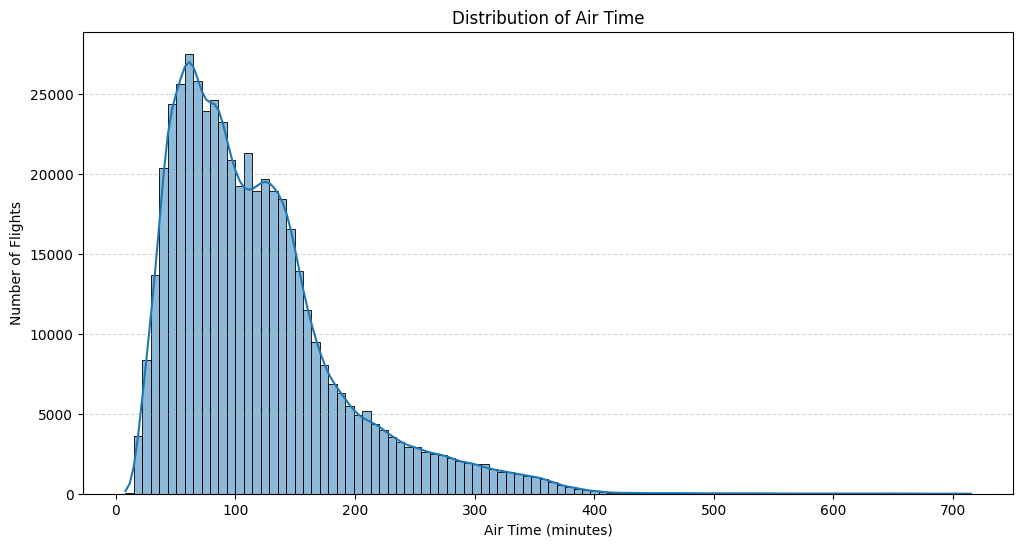

In [51]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['AIR_TIME'], bins=100, kde=True)

# Formatting
plt.title('Distribution of Air Time')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram shows that most flights have an air time of around 50 to 150 minutes, with a few flights having significantly longer air times.

#### 1.7.15 Distance
The total distance in miles between the origin and destination airports.

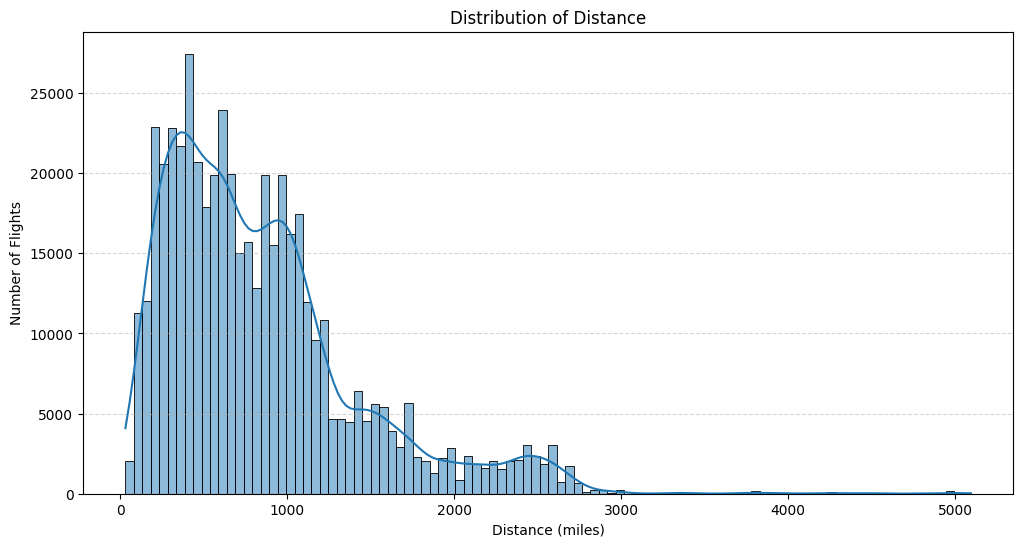

In [52]:
# Plot histogram
plt.figure(figsize=(12, 6))
sns.histplot(data=eda_df['DISTANCE'], bins=100, kde=True, kde_kws={'bw_adjust': 2})

# Formatting
plt.title('Distribution of Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Number of Flights')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The histogram shows that most flights travel a distance of around 500 to 1000 miles, with a few flights traveling significantly longer distances.

### 1.8 Bivariate Analysis
Arrival delay is the target. Relationship between arrival delay and other columns will be analysed.

#### 1.8.1 Arrival Delay VS Day of Month

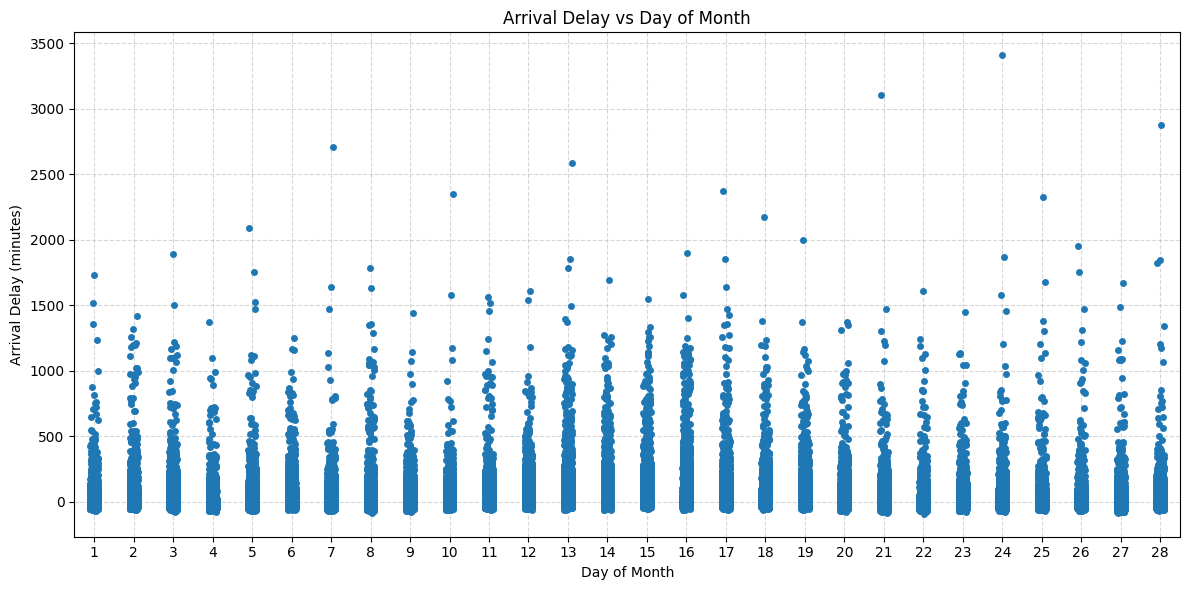

In [53]:
# Convert to DataFrame for plotting
scatter_df = eda_df.copy()
scatter_df['Day of Month'] = pd.to_datetime(scatter_df['FL_DATE']).dt.day

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='Day of Month', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Day of Month')
plt.xlabel('Day of Month')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The strip plot indicates that the day of month does not have a significant impact on the distribution of arrival delays.

#### 1.8.2 Arrival Delay VS Day of Week

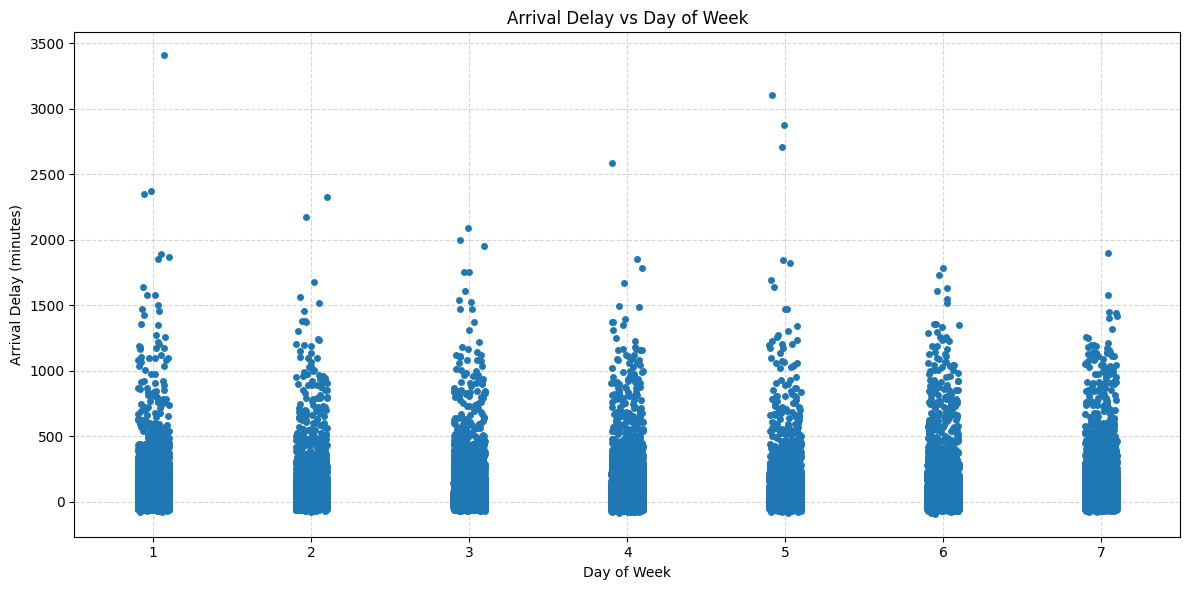

In [54]:
# Map numeric day to weekday name
scatter_df['DAY_OF_WEEK'].map(day_map)

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='DAY_OF_WEEK', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The strip plot indicates that the day of week does not have a significant impact on the distribution of arrival delays.

#### 1.8.3 Arrival Delay VS Scheduled Departure Time

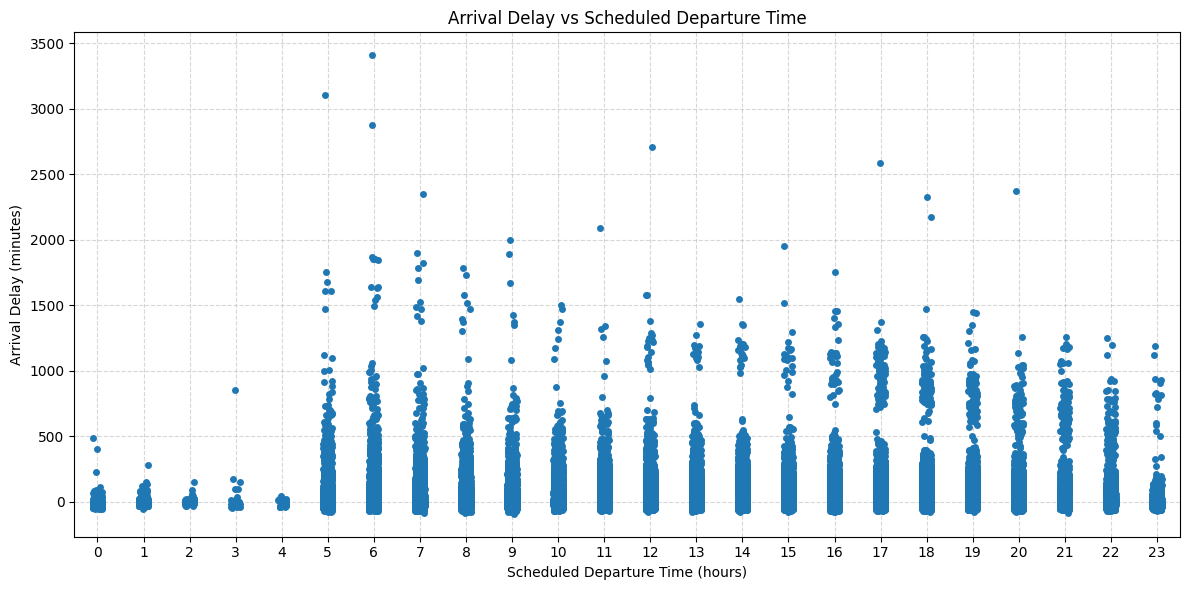

In [55]:
# Function that converts datetime.time to hour
def time_to_int_hour(time):
    if pd.isnull(time):  # Handle missing values
        return np.nan 
    return time.hour

# Apply time to hour conversion
scatter_df['SCHE_DEP'] = scatter_df['SCHE_DEP'].apply(time_to_int_hour)

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='SCHE_DEP', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Scheduled Departure Time')
plt.xlabel('Scheduled Departure Time (hours)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
- The strip plot shows that flights scheduled to depart between 00:00 to 04:00 tend to have lower arrival delays, mostly under 500 minutes.
- Flights scheduled to depart between 05:00 to 23:00 tend to have more arrival delays, including some extreme cases over 3000 minutes.

#### 1.8.4 Arrival Delay VS Actual Departure Time

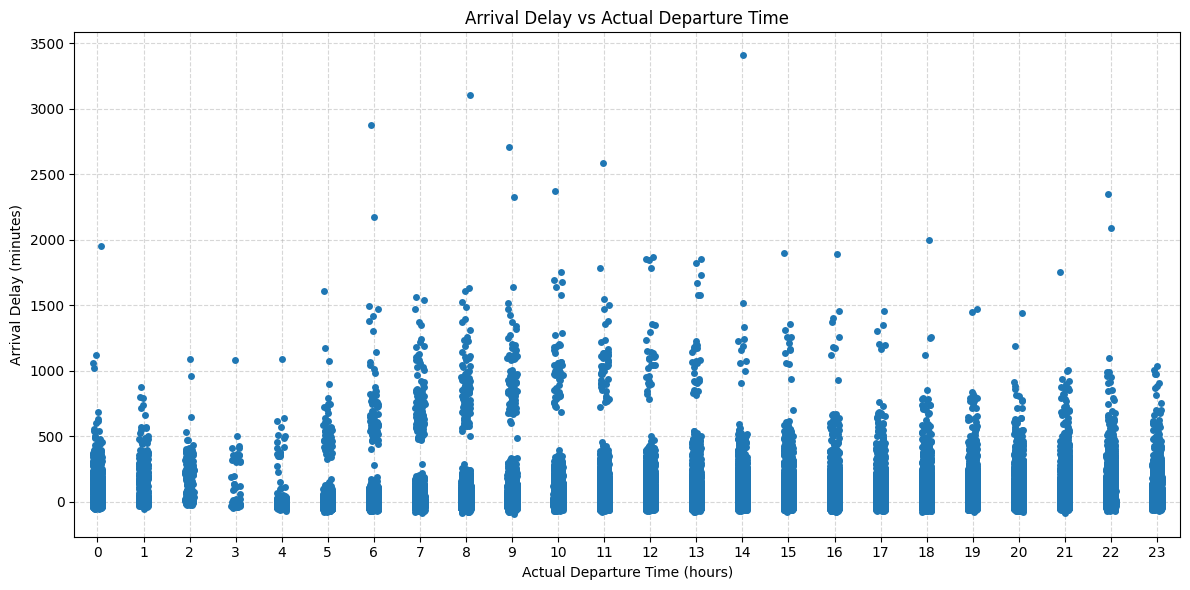

In [56]:
# Apply time to hour conversion
scatter_df['ACTU_DEP'] = scatter_df['ACTU_DEP'].apply(time_to_int_hour)

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='ACTU_DEP', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Actual Departure Time')
plt.xlabel('Actual Departure Time (hours)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The strip plot shows that flights actually depart between 00:00 to 04:00 tend to have lower arrival delays, while flights actually depart between 05:00 to 23:00 tend to have more arrival delays, similar to the schedule departure time.


#### 1.8.5 Arrival Delay VS Departure Delay

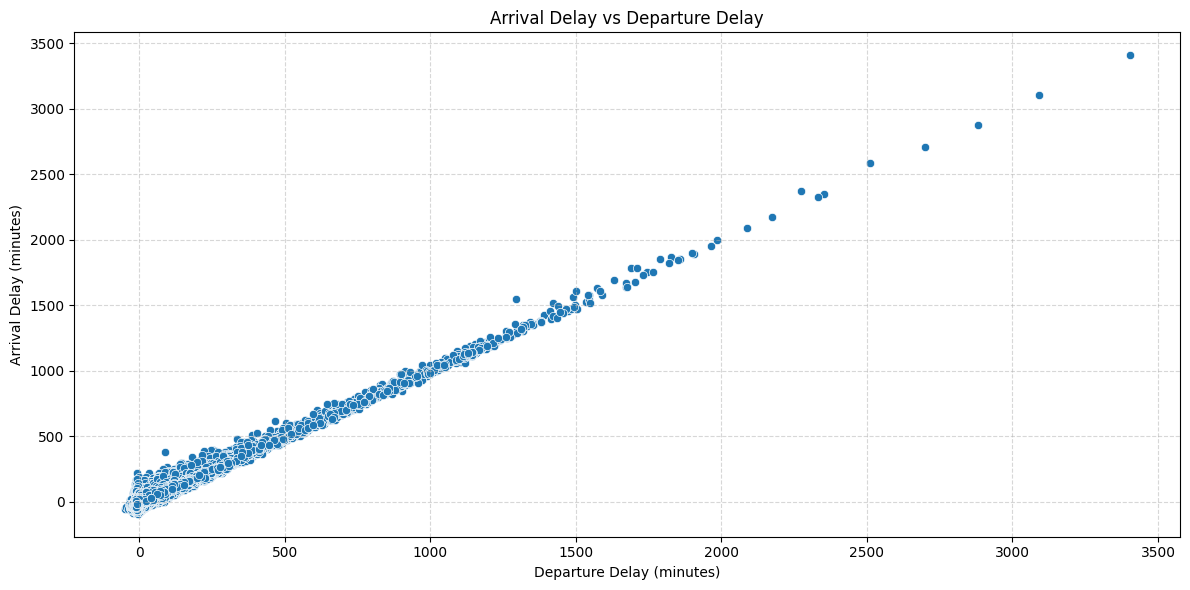

In [57]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_df, x='DEP_DELAY', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Departure Delay')
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
There is a strong positive correlation between departure delay and arrival delay.

#### 1.8.7 Arrival Delay VS Scheduled Arrival Time

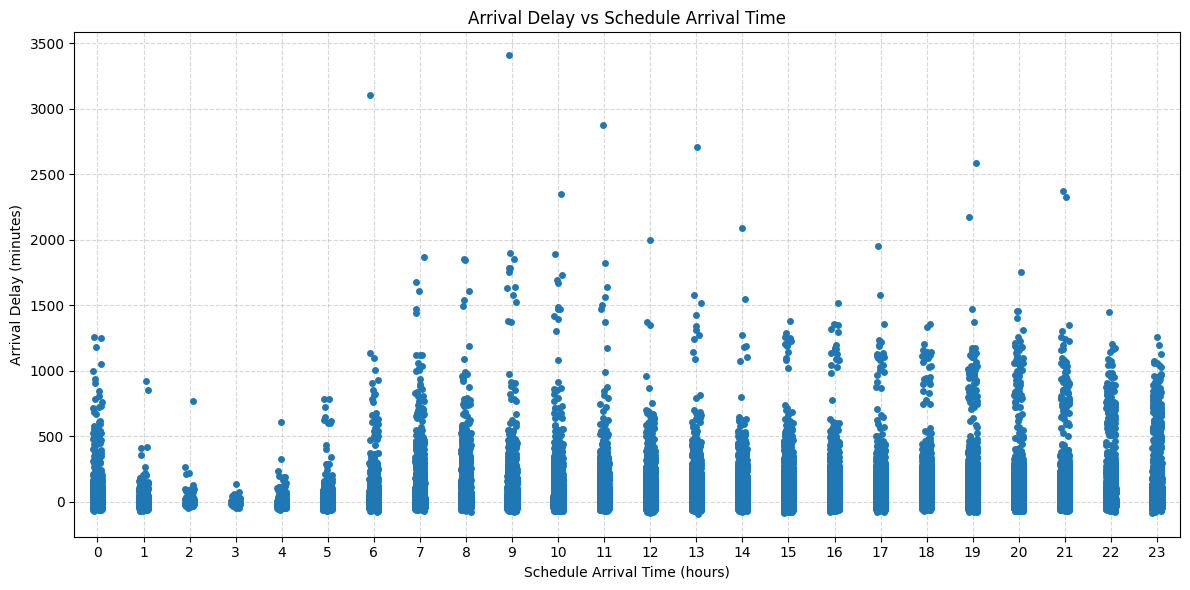

In [58]:
# Apply time to hour conversion
scatter_df['SCHE_ARR'] = scatter_df['SCHE_ARR'].apply(time_to_int_hour)

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='SCHE_ARR', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Schedule Arrival Time')
plt.xlabel('Schedule Arrival Time (hours)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The strip plot shows that flights scheduled to arrive between 01:00 to 05:00 tend to have lower arrival delays, while flights scheduled to arrive between 06:00 to 00:00 tend to have more arrival delays. It is a consistent pattern to the schedule departure time, but with 1 hour time lag.

#### 1.8.8 Arrival Delay VS Actual Arrival Time

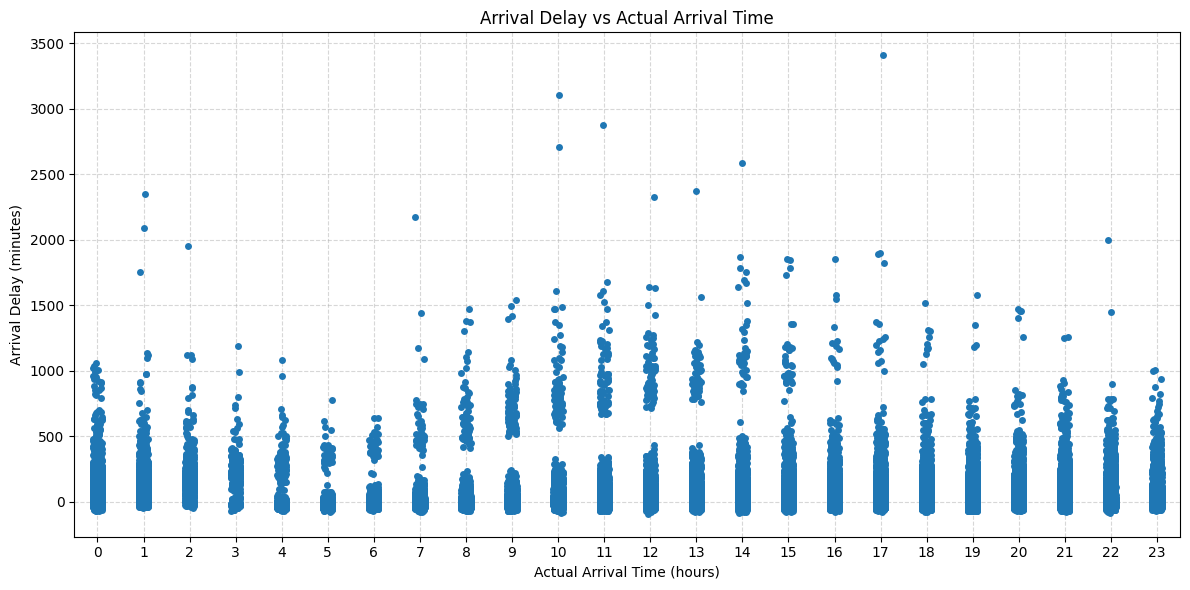

In [59]:
# Apply time to hour conversion
scatter_df['ACTU_ARR'] = scatter_df['ACTU_ARR'].apply(time_to_int_hour)

# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='ACTU_ARR', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Actual Arrival Time')
plt.xlabel('Actual Arrival Time (hours)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The strip plot shows that flights actually arrive between 02:00 to 06:00 tend to have lower arrival delays, while flights scheduled to arrive between 07:00 to 01:00 tend to have more arrival delays. It is a consistent pattern to the schedule arrival time, but with 1 hour time lag.

#### 1.8.9 Arrival Delay VS Airline

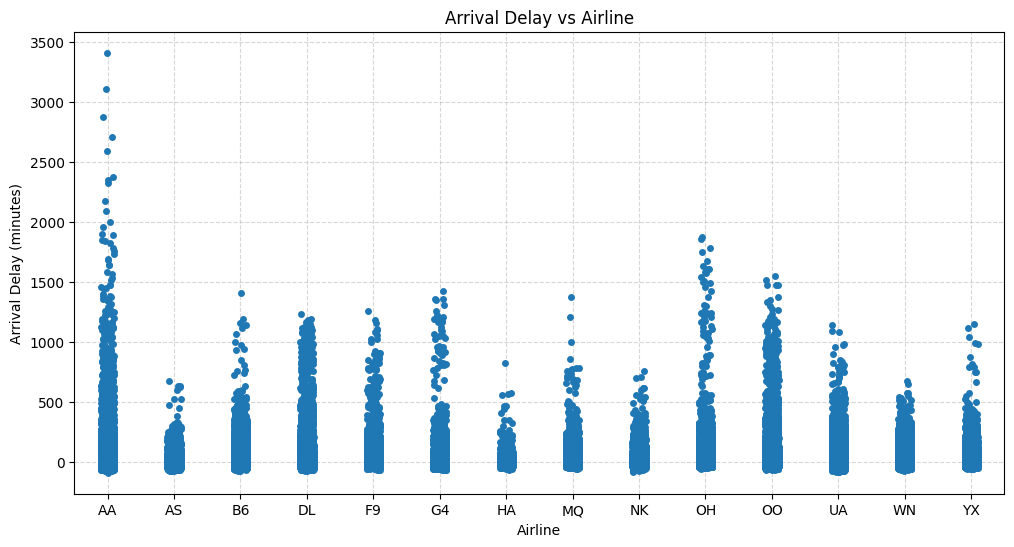

In [60]:
# Strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=scatter_df, x='AIRLINE', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Airline')
plt.xlabel('Airline')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The strip chart shows that AA tends to have more severe delay, while others have milder delays.

#### 1.8.10 Arrival Delay VS Origin Airport

Check the number of origin airports in the dataset

In [61]:
print(f"Number of origin airports: {len(scatter_df['ORIGIN'].unique())}")

Number of origin airports: 330


Since the number of airports is quite large, a subset of the data choosing from the top and bottom 10 origin airports with the highest arrival delay.

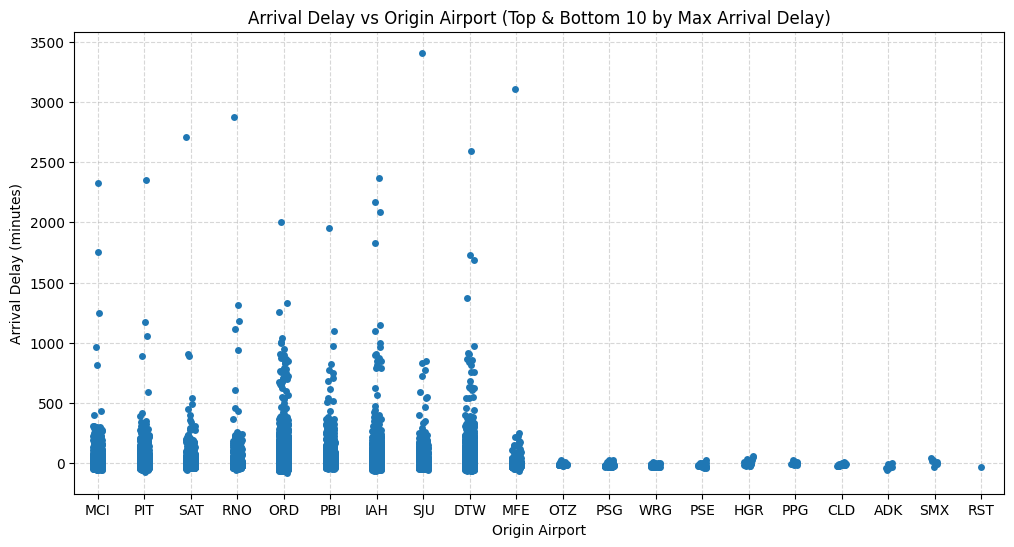

In [62]:
# Calculate max arrival delay per airport
max_delay_by_origin = scatter_df.groupby('ORIGIN')['ARR_DELAY'].max()

# Get top 10 airports by max delay
top_origin = max_delay_by_origin.nlargest(10).index
bottom_origin = max_delay_by_origin.nsmallest(10).index

# Combine both sets
selected_origin = top_origin.union(bottom_origin)

# Filter original DataFrame
filter_origin = scatter_df[scatter_df['ORIGIN'].isin(selected_origin)]

# Plot strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=filter_origin, x='ORIGIN', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Origin Airport (Top & Bottom 10 by Max Arrival Delay)')
plt.xlabel('Origin Airport')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The strip plot shows that different origin airports have significant different distributions of arrival delays.

#### 1.8.11 Arrival Delay VS Destination Airport

Check the number of origin airports in the dataset

In [63]:
print(f"Number of destination airports: {len(scatter_df['DEST'].unique())}")

Number of destination airports: 330


Since the number of airports is quite large, a subset of the data choosing from the top and bottom 10 destination airports with the highest arrival delay.

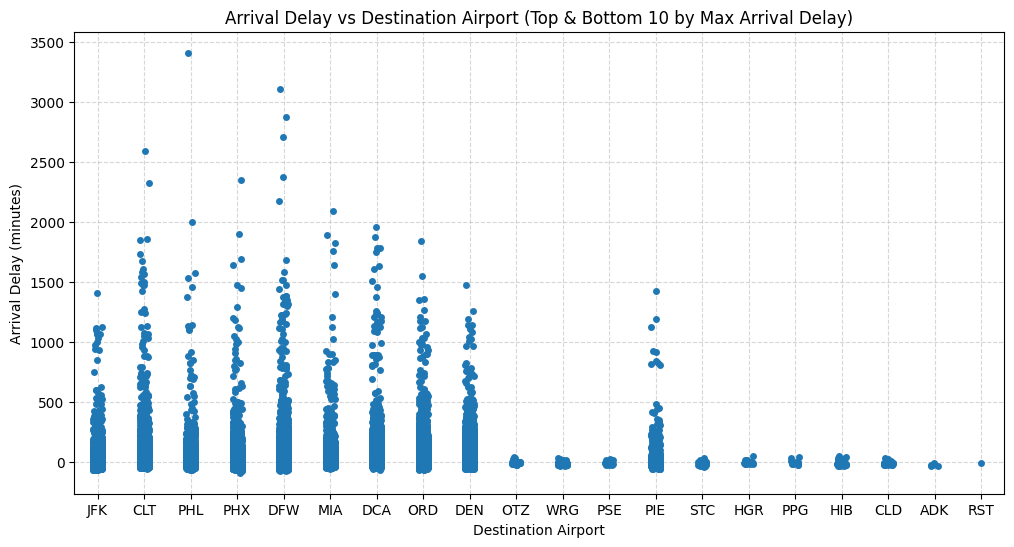

In [64]:
# Calculate max arrival delay per airport
max_delay_by_dest = scatter_df.groupby('DEST')['ARR_DELAY'].max()

# Get top 10 airports by max delay
top_dest = max_delay_by_dest.nlargest(10).index
bottom_dest = max_delay_by_dest.nsmallest(10).index

# Combine both sets
selected_dest = top_dest.union(bottom_dest)

# Filter destination DataFrame
filter_dest = scatter_df[scatter_df['DEST'].isin(selected_dest)]

# Plot strip plot
plt.figure(figsize=(12, 6))
sns.stripplot(data=filter_dest, x='DEST', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Destination Airport (Top & Bottom 10 by Max Arrival Delay)')
plt.xlabel('Destination Airport')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

##### Inference:
The strip plot shows that different destination airports have significant different distributions of arrival delays, similar to origin airports.

#### 1.8.12 Arrival Delay VS Estimated Elapsed Time

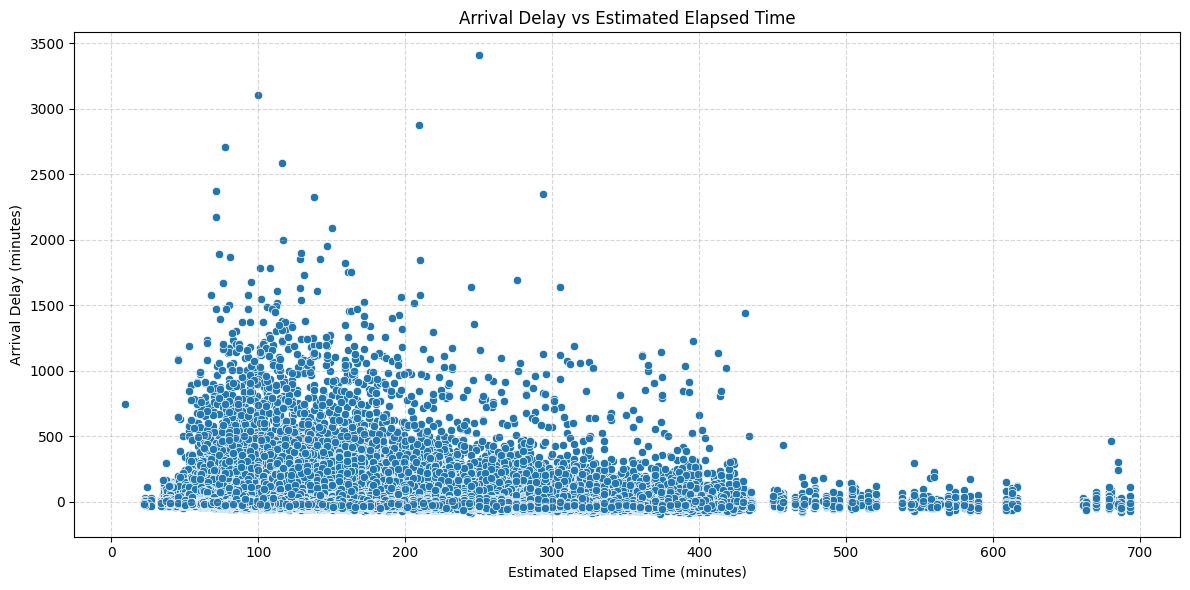

In [65]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_df, x='EST_ELAPSED', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Estimated Elapsed Time')
plt.xlabel('Estimated Elapsed Time (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
- Short-to-medium-haul flights with estimated elapsed times under 400 minutes show more arrival delays, even exceeding 3000 minutes.
- Long-haul flights with estimated elapsed times between 400 to 700 minutes tend to have lower arrival delays.


#### 1.8.14 Arrival Delay VS Actual Elapsed Time

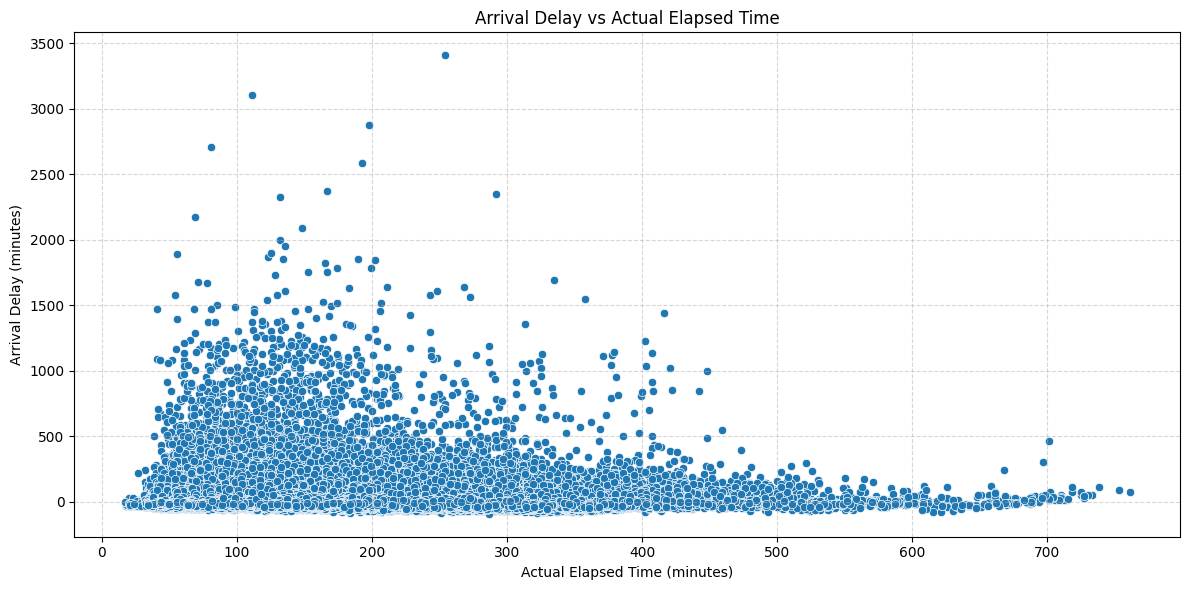

In [66]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_df, x='ACTU_ELAPSED', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Actual Elapsed Time')
plt.xlabel('Actual Elapsed Time (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
- Short-to-medium-haul flights with actual elapsed times under 400 minutes show more arrival delays, even exceeding 3000 minutes.
- Long-haul flights with actual elapsed times between 400 to 700 minutes tend to have lower arrival delays.
- The pattern is similar to the estimated elapsed time.

#### 1.8.15 Arrival Delay VS Air Time

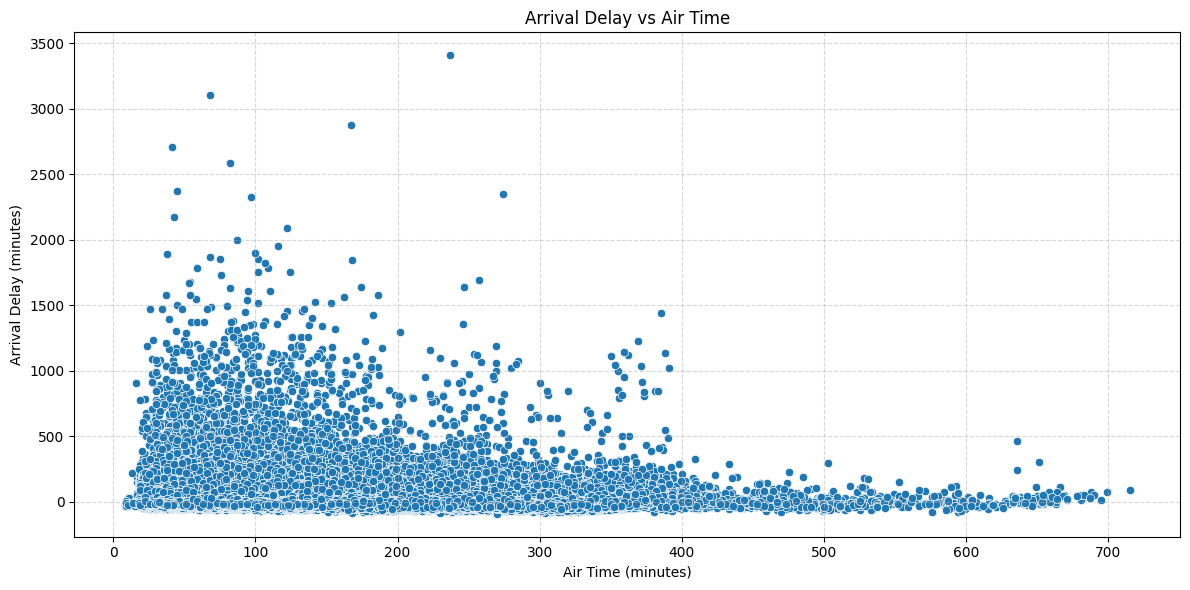

In [67]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_df, x='AIR_TIME', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Air Time')
plt.xlabel('Air Time (minutes)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
- Short-to-medium-haul flights with air times under 400 minutes show more arrival delays, even exceeding 3000 minutes.
- Long-haul flights with air times between 400 to 700 minutes tend to have lower arrival delays.
- The pattern is similar to the estimated and actual elapsed time.

#### 1.8.16 Arrival Delay VS Distance

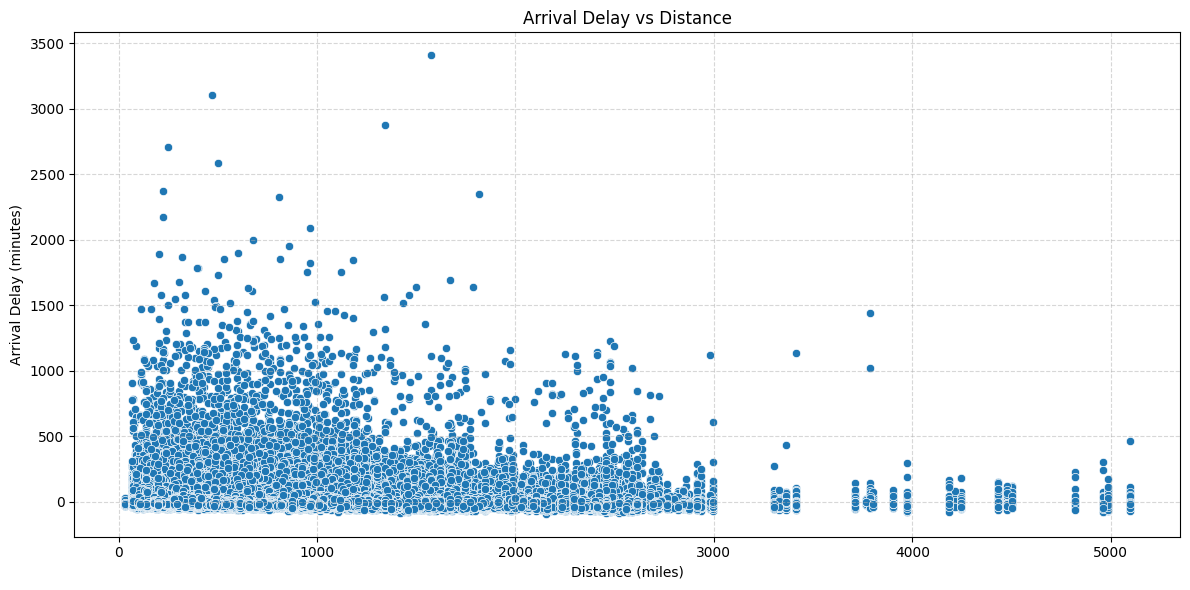

In [68]:
# Scatter plot
plt.figure(figsize=(12, 6))
sns.scatterplot(data=scatter_df, x='DISTANCE', y='ARR_DELAY')

# Formatting
plt.title('Arrival Delay vs Distance')
plt.xlabel('Distance (miles)')
plt.ylabel('Arrival Delay (minutes)')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

##### Inference:
The scatter plot does not show a clear trend, indicating that the distance of the flight does not have a significant impact on the arrival delay.

#### Conclusion:
Based on the bivariate analysis, the features that have an impact on arrival delay are:  
- Scheduled Departure Time  
- Actual Departure Time  
- Departure Delay  
- Scheduled Arrival Time  
- Actual Arrival Time 
- Airline  
- Origin Airport  
- Destination Airport  
- Estimated Elapsed Time  
- Actual Elapsed Time  
- Air Time  

On the other hand, the following features do not seem to significantly influence arrival delay:  
- Day of Month  
- Day of Week  
- Distance  

### 1.9 Multivariate Analysis
Explore the interactions between different features of the dataset and how they collectively impact the target variable: Arrival delay.

The choice of features considered is based on the results from the bivariate analysis:
- Scheduled Departure Time  
- Actual Departure Time  
- Departure Delay  
- Scheduled Arrival Time  
- Actual Arrival Time 
- Airline  
- Origin Airport  
- Destination Airport  
- Estimated Elapsed Time  
- Actual Elapsed Time  
- Air Time 

#### 1.9.1 Correlation between Numerical Features

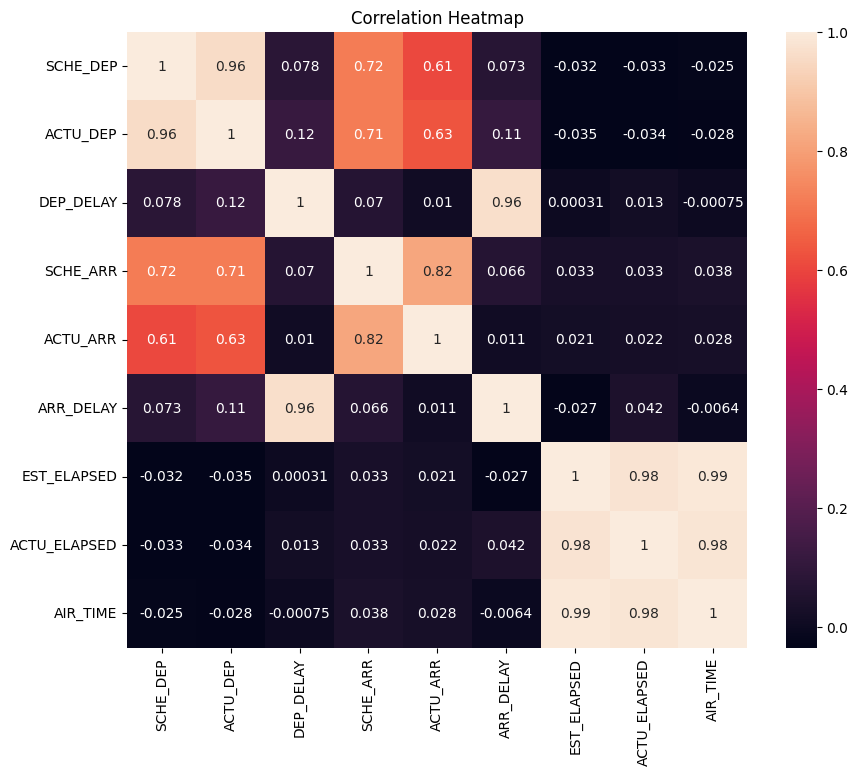

In [69]:
# Copy the DataFrame for multivariate analysis
correlation_df = eda_df.copy()

# Apply time_to_hour conversion to relevant columns
time_columns = ['SCHE_DEP', 'ACTU_DEP', 'SCHE_ARR', 'ACTU_ARR']
for col in time_columns:
    correlation_df[col] = correlation_df[col].apply(time_to_hour)

# For correlation heatmap, let's consider the numeric features only
numeric_corr_features = ['SCHE_DEP', 'ACTU_DEP', 'DEP_DELAY', 'SCHE_ARR', 'ACTU_ARR', 'ARR_DELAY','EST_ELAPSED', 'ACTU_ELAPSED', 'AIR_TIME']
correlation_matrix = correlation_df[numeric_corr_features].corr()

plt.figure(figsize=(10,8))
sns.heatmap(correlation_matrix, annot=True)
plt.title('Correlation Heatmap')
plt.show()

##### Inference:
Timing Metrics  
- Scheduled and Actual Departure Time shows very strong positive correlations as actual departures closely follow scheduled times.
- Scheduled and Actual Arrival Time shows strong positive correlations as actual arrival times are generally aligned with schedules.
- However, they show weak correlations with Arrival Delay.

Flight Duration Metrics  
- Estimated Elapsed Time, Actual Elapsed Time and Air Time show near-perfect positive correlations as these metrics are tightly linked and measure similar aspects of flight duration, which also indicating that these metrics are redundant for analysis or modelling.
- However, they show very weak correlations with Arrival Delay. Therefore, only Estimated Elapsed Time is chosen for later analysis.

Delay Behavior  
- Departure Delay shows low correlations with most other variables, suggesting that departure delays are not strongly predictable from scheduled or actual times alone, but it is strongly positive correlate with Arrival Delay.
- Departure Delay is a key feature for predicting Arrival Delay.


#### 1.9.2 Average Arrival Delay by Origin and Destination Airport
Objective: identify route-level delay patterns

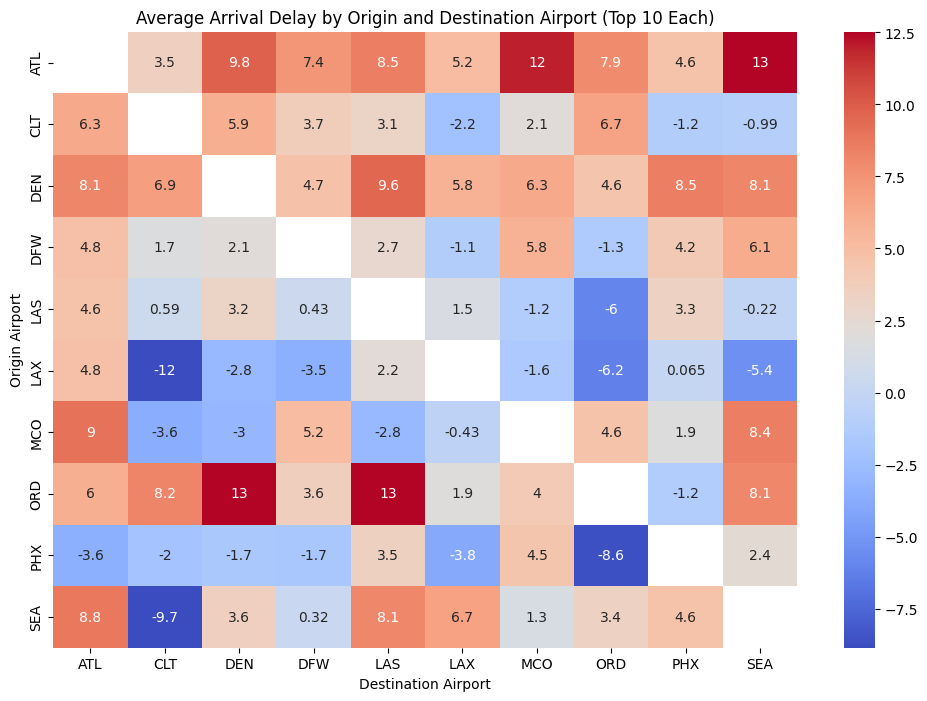

In [70]:
# Get top 10 origin and destination airports by flight count
top_origin_heatmap = correlation_df['ORIGIN'].value_counts().nlargest(10).index
top_dest_heatmap = correlation_df['DEST'].value_counts().nlargest(10).index

# Filter the DataFrame
top_origin_dest = correlation_df[
    correlation_df['ORIGIN'].isin(top_origin_heatmap) &
    correlation_df['DEST'].isin(top_dest_heatmap)
]

# Create pivot table of average arrival delay
origin_dest_heatmap = top_origin_dest.pivot_table(
    index='ORIGIN',
    columns='DEST',
    values='ARR_DELAY',
    aggfunc='mean'
)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=origin_dest_heatmap, annot=True, cmap='coolwarm', robust=True)

# Formatting
plt.title('Average Arrival Delay by Origin and Destination Airport (Top 10 Each)')
plt.xlabel('Destination Airport')
plt.ylabel('Origin Airport')
plt.show()

##### Inference:
- ORD → DEN & LAS: Both show 13-minute average delays, indicating consistent issues on these routes.
- ATL → SEA (13 min) and ATL → MCO (12 min): Long delays from Atlanta to western hubs.
- DEN and ALT tend to have moderate delays across most destinations.




### 1.10 Data Preprocessing
Cleaning and transforming raw data into a format that can be understood by machine learning algorithms.

#### 1.10.1 Relevant Feature Selection

**Numerical Feature:**
- Departure Delay  
- Arrival Delay

Departure Delay is the only numerical feature exhibiting a strong correlation with Arrival Delay, as shown in the multivariate correlation heatmap.  
Arrival Delay is the target feature.

**Categorical Features:**
- Airline
- Origin Airport
- Destination Airport  

These categorical variables show a notable influence on Arrival Delay based on the bivariate analysis.

In [71]:
# Select relevant features
clean_df = df[['DEP_DELAY', 'AIRLINE', 'ORIGIN', 'DEST', 'ARR_DELAY']]

# Check the list of selected features
clean_df.columns

Index(['DEP_DELAY', 'AIRLINE', 'ORIGIN', 'DEST', 'ARR_DELAY'], dtype='object')

#### 1.10.2 Missing Value Treatment

In [72]:
# Check the percentage of missing values in each column
missing_percent = clean_df.isnull().mean().sort_values(ascending=False) * 100
print(f"Missing Value % by Columns: \n{round(missing_percent,2)}")

Missing Value % by Columns: 
ARR_DELAY    1.67
DEP_DELAY    1.41
AIRLINE      0.00
ORIGIN       0.00
DEST         0.00
dtype: float64


#### Inference
- There are some missing values in the target column (ARR_DELAY). Rows with missing values in the target column will be removed to avoid introducing bias into our model.  
- There is only 1.41% missing value in Departure Delay and the dataset is large, I decide to proceed by removing the entries that contain the missing values instead of imputing them.

In [73]:
# Drop rows where any of these columns have NaN
clean_df.dropna(inplace=True)
clean_df.reset_index(drop=True, inplace=True)

# Check the summary of the dataset again
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 496476 entries, 0 to 496475
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   DEP_DELAY  496476 non-null  float64
 1   AIRLINE    496476 non-null  object 
 2   ORIGIN     496476 non-null  object 
 3   DEST       496476 non-null  object 
 4   ARR_DELAY  496476 non-null  float64
dtypes: float64(2), object(3)
memory usage: 18.9+ MB


#### 1.10.3 Outlier Treatment
The outliers in the dataset represent the real delay incidents, but not due to errors or mistakes. Thus, the outliers should be preserved.  
Yet, extreme influence from the outliers should be reduced by Yeo-Johnson Transformation in the prediction model. This process will be done in the later section.

#### 1.10.4 Categorical Features Encoding
Machine learning algorithms work with numerical data but not categorical data. Therefore, categorical variables need to be encoded.

In [74]:
# Identify categorical columns
cat_columns = clean_df.select_dtypes(include=['object']).columns

# Check the number of unique categories in each categorical feature
clean_df[cat_columns].nunique()

AIRLINE     14
ORIGIN     330
DEST       330
dtype: int64

#### Inference
- AIRLINE: With only 14 categories, whcih is low cardinality, so one-hot encoding method can work.
- ORIGIN and DEST: Each with 330 categories, which are high-cardinality features, so methods that can keep dimensionality low while preserving predictive power will be used. Target encoding within cross-validation folds will be applied based on training data only during modele building to mitigate the risk of data leakage and overfitting.

In [75]:
# Apply one-hot encoding to airlines
clean_df = pd.get_dummies(clean_df, columns=['AIRLINE'], prefix='AIRLINE', drop_first=True)

# Show the result
clean_df.head()

,DEP_DELAY,ORIGIN,DEST,ARR_DELAY,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_F9,AIRLINE_G4,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OH,AIRLINE_OO,AIRLINE_UA,AIRLINE_WN,AIRLINE_YX
0,-3.0,JFK,LAX,-14.0,False,False,False,False,False,False,False,False,False,False,False,False,False
1,17.0,LAX,JFK,8.0,False,False,False,False,False,False,False,False,False,False,False,False,False
2,54.0,JFK,SFO,71.0,False,False,False,False,False,False,False,False,False,False,False,False,False
3,-12.0,SFO,JFK,-35.0,False,False,False,False,False,False,False,False,False,False,False,False,False
4,-2.0,SFO,JFK,-29.0,False,False,False,False,False,False,False,False,False,False,False,False,False


#### 1.10.5 Define the Target Variable
The flight is considered to be delayed if the arrival delay is greater than 15 minutes.

In [76]:
# Create binary target: 1 if delayed > 15 minutes, else 0
clean_df['DELAYED'] = (clean_df['ARR_DELAY'] > 15).astype(int)

# Show the result
clean_df.head()

,DEP_DELAY,ORIGIN,DEST,ARR_DELAY,AIRLINE_AS,AIRLINE_B6,AIRLINE_DL,AIRLINE_F9,AIRLINE_G4,AIRLINE_HA,AIRLINE_MQ,AIRLINE_NK,AIRLINE_OH,AIRLINE_OO,AIRLINE_UA,AIRLINE_WN,AIRLINE_YX,DELAYED
0,-3.0,JFK,LAX,-14.0,False,False,False,False,False,False,False,False,False,False,False,False,False,0
1,17.0,LAX,JFK,8.0,False,False,False,False,False,False,False,False,False,False,False,False,False,0
2,54.0,JFK,SFO,71.0,False,False,False,False,False,False,False,False,False,False,False,False,False,1
3,-12.0,SFO,JFK,-35.0,False,False,False,False,False,False,False,False,False,False,False,False,False,0
4,-2.0,SFO,JFK,-29.0,False,False,False,False,False,False,False,False,False,False,False,False,False,0


#### 1.10.6 Select Features for Modeling
Identify the input features and output target for the model.

In [77]:
# Select features: DEP_DELAY, ORIGIN, DEST, and all one-hot encoded columns
X = clean_df.drop(['ARR_DELAY', 'DELAYED'], axis=1)

# Select target: DELAYED
y = clean_df['DELAYED']

## 2 Model Building
Objective: Train and evaluate a model to predict delays.

In [78]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Define feature groups for the pipeline
categorical_cols = ['ORIGIN', 'DEST']  # Categorical features
dep_delay_col = ['DEP_DELAY']          # Feature requiring Yeo-Johnson transformation
feature_names = categorical_cols + dep_delay_col


# Preprocessing for categorical features: Apply target encoding
cat_transformer = Pipeline(steps=[
    ('encoder', TargetEncoder())
])

# Preprocessing for DEP_DELAY: Apply Yeo-Johnson transformation
dep_delay_transformer = Pipeline(steps=[
    ('transformer', PowerTransformer(method='yeo-johnson'))
])

# Combine all preprocessing steps into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_transformer, categorical_cols),
        ('dep_delay', dep_delay_transformer, dep_delay_col),
    ]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(eval_metric='logloss', random_state=0))
])


# Randomized hyperparameter search
param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [3, 5, 7],
    'classifier__learning_rate': np.linspace(0.01, 0.2, 5),
    'classifier__subsample': [0.6, 0.8, 1.0],
    'classifier__colsample_bytree': [0.6, 0.8, 1.0],
    'classifier__scale_pos_weight': [1, 3, 5]  # Adjust for class imbalance
}

randomized_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_dist,
    n_iter=20,
    scoring='f1',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=0
)

# Run search and evaluate
randomized_search.fit(X_train, y_train)
print("Best Parameters:", randomized_search.best_params_)

# Predict and evaluate
y_pred = randomized_search.best_estimator_.predict(X_test)
y_proba = randomized_search.best_estimator_.predict_proba(X_test)[:, 1]

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best Parameters: {'classifier__subsample': 0.8, 'classifier__scale_pos_weight': 1, 'classifier__n_estimators': 200, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 0.8}
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95     79519
           1       0.90      0.70      0.79     19777

    accuracy                           0.92     99296
   macro avg       0.92      0.84      0.87     99296
weighted avg       0.92      0.92      0.92     99296

AUC-ROC Score: 0.9303495118854253


#### Inference
- The overall performance is strong - 92% correct predictions across the board.
- THe AUC-ROC score is 0.93, which indicates excellent discrimination between delayed vs non-delay flights.
- Recall for Delayed Flights (class 1) is 0.70, whcih means there is a weak point in the model and about 30% of actual delays go undetected.

## 3 Model Explainability
Objective: Identify key delay predictors using SHAP (SHapley Additive exPlanations).

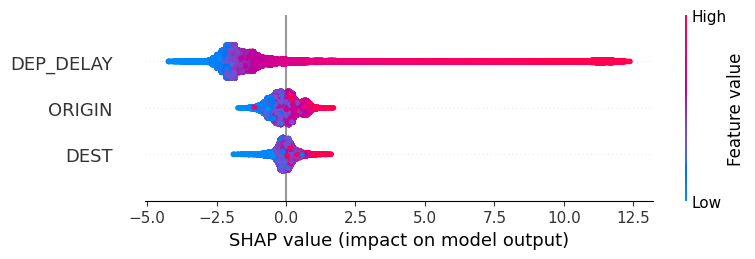

In [79]:
# Grab the trained pipeline from randomized search
best_pipeline = randomized_search.best_estimator_

# Extract the fitted XGBoost model
xgb_model = best_pipeline.named_steps['classifier']

# Transform test data using the fitted preprocessor
X_test_prepped = best_pipeline.named_steps['preprocessor'].transform(X_test)

# Create SHAP explainer and compute values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_prepped)

# Plot summary
shap.summary_plot(shap_values, X_test_prepped, feature_names=feature_names)

#### Inference
- The dominant feature of prediction is DEP_DELAY as it has high values of positive SHAP and low values of negative SHAP, indicating that the more a flight is delayed at departure, the more likely the model thinks it will be late on arrival.
- The ORIGIN and DEST airports has much smaller predictive impact as their SHAP value clustered around zero, but the slight spread suggests some airports are consistently delay-prone, while others are not.


## 4 Discussion
The SHAP-powered insights from the XGBoost model can drive strategic advantage, operational excellence, and customer satisfaction across with the following actions:

##### 1. Strategize Around Delay-Prone Airports
- Identify which ORIGIN and DEST airports are top contributors to delay risk.
- Allocate resources more efficiently: more ground staff, better gate management, or negotiated slot improvements at high-risk hubs.
- Shape network planning: re-evaluate routing through problematic nodes or build delay-tolerant schedules.

##### 2. Implement Smart Delay Mitigation Protocols
- Early warning system: Use the model to flag flights likely to experience delays before departure.
- Fast-track preemptive measures - crew rotations, aircraft swaps, or passenger rerouting - when confidence in delay risk exceeds thresholds.

##### 3. Improve Scheduling Intelligence
- Delay impact from DEP_DELAY shows temporal dependencies: adjust turnaround time, hold buffers, or gate usage based on time-of-day patterns.
- Fine-tune schedules by learning from SHAP correlations between departure delays and arrival bottlenecks.

##### 4. Personalize Passenger Communications
- For flights flagged as high-risk, proactively inform travelers with:
- “Heads-up” delay alerts
- Faster rebooking options
- Compensation credits before complaints roll in
This turns a potential grievance into loyalty.

##### 5. Present Transparent KPIs to Regulators & Investors
- SHAP plots visualize why delays happen — perfect for ESG reports, government audits, and shareholder briefings.
- Show that the aviation industry is using AI to make data-driven, ethical, and customer-centric decisions.

## 5 Model Deployment
Model deployment simulation to Streamlit

In [80]:
import joblib

# Save pipeline from randomized search
joblib.dump(best_pipeline, "delay_pipeline.pkl")

['delay_pipeline.pkl']